<a href="https://colab.research.google.com/github/lucadaD/Daboifromnowhere/blob/main/SMB_v5_wSENTIMENT_gmn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- CELL 1: IMPORTS & CONFIGURATION ---
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO
from zipfile import ZipFile

# Cấu hình hiển thị
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✅ Môi trường đã sẵn sàng!")

✅ Môi trường đã sẵn sàng!


In [ ]:
# --- CELL 2: MODULE TẢI DỮ LIỆU ---

def get_fama_french_daily(start_date='2020-01-01'):
    """
    Tải dữ liệu Fama-French 3 Factors daily trực tiếp từ nguồn Kenneth French.
    Xử lý: Chuyển đổi phần trăm, format ngày tháng.
    """
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"

    try:
        r = requests.get(url)
        z = ZipFile(BytesIO(r.content))
        csv_name = z.namelist()[0]

        # Đọc CSV, bỏ footer/header rác
        df = pd.read_csv(z.open(csv_name), skiprows=3)
        df = df.rename(columns={"Unnamed: 0": "Date"})

        # Lọc dòng lỗi và format Date
        df = df[df['Date'].astype(str).str.strip().str.isnumeric().fillna(False)]
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
        df = df.set_index('Date')

        # Chuyển về dạng số thập phân (Raw data là %, ví dụ 0.5 -> 0.005)
        df = df.astype(float) / 100
        df.columns = ['Mkt-RF', 'SMB', 'HML', 'RF']

        # Lọc theo start_date
        return df.loc[start_date:]

    except Exception as e:
        print(f"❌ Lỗi tải Fama-French: {e}")
        return pd.DataFrame()

def get_stock_data(tickers, start_date):
    """
    Tải dữ liệu giá đóng cửa điều chỉnh (Adj Close) từ yfinance.
    Xử lý: Timezone, MultiIndex, Missing Data.
    """
    print(f"📥 Đang tải dữ liệu cho {len(tickers)} mã cổ phiếu...")
    raw = yf.download(tickers, start=start_date, progress=False, auto_adjust=False)

    # Xử lý cột (MultiIndex hay Single Index)
    if isinstance(raw.columns, pd.MultiIndex):
        try:
            df = raw['Close']
        except KeyError:
            df = raw['Close'] # Fallback nếu không có Adj Close
    else:
        df = raw['Close']

    # QUAN TRỌNG: Xóa Timezone để khớp với FF Data
    if df.index.tz is not None:
        df.index = df.index.tz_localize(None)

    # Tính Daily Returns
    returns = df.pct_change().dropna(how='all')

    print(f"✅ Đã tải xong. Kích thước dữ liệu: {returns.shape}")
    return returns

In [ ]:
# --- CELL 3: MODULE TÍNH TOÁN FACTOR & METRICS ---

def calculate_smb_proxy(df_returns, small_ticker='^RUT', big_ticker='^GSPC'):
    """
    Tính SMB Proxy dựa trên chênh lệch return của Small Cap Index và Big Cap Index.
    """
    if small_ticker in df_returns.columns and big_ticker in df_returns.columns:
        smb_proxy = df_returns[small_ticker] - df_returns[big_ticker]
        return smb_proxy
    else:
        print("⚠️ Không tìm thấy ticker index trong dữ liệu để tính SMB Proxy.")
        return pd.Series(dtype=float)

def calculate_csad(df_returns):
    """
    Tính Market Dispersion (CSAD).
    Công thức: CSAD_t = Mean( |R_i,t - R_m,t| )
    """
    # 1. Market Return (Equal Weighted cho rổ cổ phiếu hiện tại)
    # Lưu ý: Có thể dùng Value Weighted nếu có Market Cap, nhưng Equal Weight nhạy hơn với Herding.
    rm_hat = df_returns.mean(axis=1)

    # 2. Độ lệch tuyệt đối
    abs_dev = df_returns.sub(rm_hat, axis=0).abs()

    # 3. CSAD
    csad = abs_dev.mean(axis=1)

    return pd.DataFrame({'Rm_Basket': rm_hat, 'CSAD': csad})

def calculate_rolling_sentiment_beta(target_return, market_metrics, window=60):
    """
    Chạy hồi quy trượt để tìm độ nhạy cảm của cổ phiếu với CSAD.
    Model: R_i = alpha + beta_mkt * Rm + beta_sent * CSAD + error
    """
    # Merge dữ liệu
    data = pd.concat([target_return, market_metrics], axis=1).dropna()

    if len(data) < window:
        return None

    # Định nghĩa biến Y và X
    Y = data.iloc[:, 0] # Stock Return
    X = data[['Rm_Basket', 'CSAD']] # Factors
    X = sm.add_constant(X) # Thêm hệ số chặn alpha

    # Rolling OLS
    rols = RollingOLS(Y, X, window=window)
    rres = rols.fit()

    # Chỉ lấy Beta của CSAD
    return rres.params['CSAD']

In [ ]:
# --- CELL 4: CHẠY PHÂN TÍCH ---

# 1. Cấu hình tham số
START_DATE = '2023-01-01'
# Rổ cổ phiếu quan sát (Tech & Growth + Index)
TICKERS = [
    '^GSPC', '^RUT', # Index cho SMB Proxy
    'AAPL', 'MSFT', 'NVDA', 'TSLA', 'GOOGL', 'AMZN', 'META', 'AMD', # Tech Giants
    'JPM', 'XOM' # Non-tech để đối chiếu
]

# 2. Lấy dữ liệu
df_ff_official = get_fama_french_daily(START_DATE) # Data Chính chủ
df_stock_ret = get_stock_data(TICKERS, START_DATE) # Data Giá

# 3. Tính toán SMB Comparison
smb_proxy_series = calculate_smb_proxy(df_stock_ret)
# Merge để so sánh (Inner join theo ngày)
comparison_df = pd.concat([df_ff_official['SMB'], smb_proxy_series], axis=1, join='inner')
comparison_df.columns = ['SMB_Official', 'SMB_Proxy']

# 4. Tính toán CSAD & Sentiment
# Loại bỏ Index ra khỏi rổ tính CSAD để tránh bias
stock_only_ret = df_stock_ret.drop(columns=['^GSPC', '^RUT'], errors='ignore')
market_metrics = calculate_csad(stock_only_ret)

# 5. Tính Rolling Sentiment Beta cho một mã cụ thể (Ví dụ NVDA)
target_stock = 'NVDA'
nvda_sent_beta = calculate_rolling_sentiment_beta(stock_only_ret[target_stock], market_metrics, window=60)

print("\n--- KẾT QUẢ TÍNH TOÁN SƠ BỘ ---")
print("1. Thống kê CSAD:")
print(market_metrics['CSAD'].describe())
print(f"\n2. Sentiment Beta mới nhất của {target_stock}: {nvda_sent_beta.iloc[-1]:.4f}")

📥 Đang tải dữ liệu cho 12 mã cổ phiếu...
✅ Đã tải xong. Kích thước dữ liệu: (786, 12)

--- KẾT QUẢ TÍNH TOÁN SƠ BỘ ---
1. Thống kê CSAD:
count   786.0000
mean      0.0128
std       0.0060
min       0.0019
25%       0.0089
50%       0.0117
75%       0.0154
max       0.0545
Name: CSAD, dtype: float64

2. Sentiment Beta mới nhất của NVDA: 0.2497


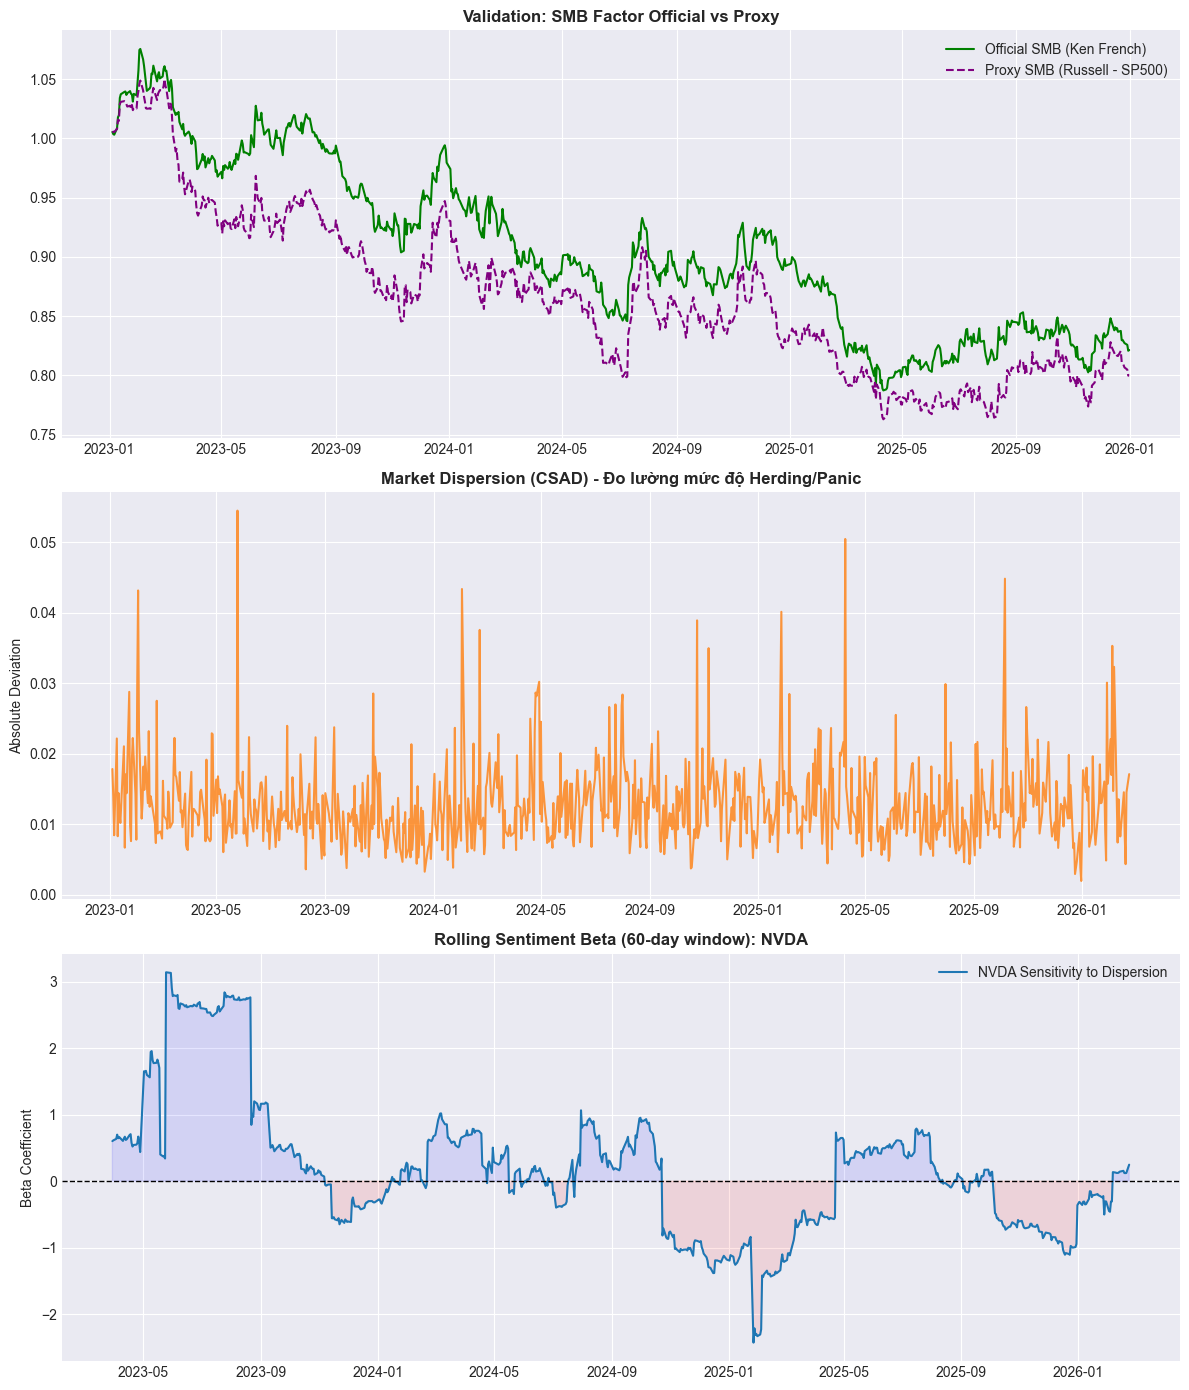

In [ ]:
# --- CELL 5: TRỰC QUAN HÓA KẾT QUẢ ---

fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=False)

# Biểu đồ 1: So sánh SMB Official vs Proxy (Cumulative)
cum_smb = (1 + comparison_df).cumprod()
axes[0].plot(cum_smb.index, cum_smb['SMB_Official'], label='Official SMB (Ken French)', color='green')
axes[0].plot(cum_smb.index, cum_smb['SMB_Proxy'], label='Proxy SMB (Russell - SP500)', color='purple', linestyle='--')
axes[0].set_title('Validation: SMB Factor Official vs Proxy', fontsize=12, fontweight='bold')
axes[0].legend()

# Biểu đồ 2: Market Dispersion (CSAD)
axes[1].plot(market_metrics.index, market_metrics['CSAD'], color='#ff7f0e', alpha=0.8)
axes[1].set_title('Market Dispersion (CSAD) - Đo lường mức độ Herding/Panic', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Absolute Deviation')

# Biểu đồ 3: Rolling Sentiment Beta của NVDA
axes[2].plot(nvda_sent_beta.index, nvda_sent_beta, color='#1f77b4', label=f'{target_stock} Sensitivity to Dispersion')
axes[2].axhline(0, color='black', linestyle='--', linewidth=1)
axes[2].set_title(f'Rolling Sentiment Beta (60-day window): {target_stock}', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Beta Coefficient')
axes[2].fill_between(nvda_sent_beta.index, 0, nvda_sent_beta, where=(nvda_sent_beta>0), color='blue', alpha=0.1)
axes[2].fill_between(nvda_sent_beta.index, 0, nvda_sent_beta, where=(nvda_sent_beta<0), color='red', alpha=0.1)
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# --- CELL 6: MODULE XÂY DỰNG TRADABLE SENTIMENT FACTOR ---
# Yêu cầu: Đã chạy các cell trước để có biến 'df_stock_ret' và 'market_metrics'

def calculate_all_rolling_betas(returns_df, market_metrics, window=60):
    """
    Tính Rolling Beta cho TOÀN BỘ cổ phiếu trong DataFrame.
    Sử dụng vòng lặp (có thể tối ưu bằng vectorization nhưng loop dễ debug hơn).
    """
    all_betas = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)

    print(f"🔄 Đang tính Rolling Beta cho {len(returns_df.columns)} mã (Window={window})...")

    # Chuẩn bị X (Market Metrics)
    X = sm.add_constant(market_metrics[['Rm_Basket', 'CSAD']])

    for ticker in returns_df.columns:
        try:
            y = returns_df[ticker]
            # Kết hợp dữ liệu để đảm bảo khớp ngày
            data = pd.concat([y, X], axis=1).dropna()

            if len(data) < window:
                continue

            # Rolling OLS
            # Lưu ý: RollingOLS của statsmodels đòi hỏi index phải khớp hoàn toàn
            model = RollingOLS(data[ticker], data[['const', 'Rm_Basket', 'CSAD']], window=window)
            results = model.fit()

            # Lưu lại Beta CSAD vào DataFrame tổng
            # Cần reindex lại về index gốc để tránh mất ngày
            all_betas[ticker] = results.params['CSAD'].reindex(all_betas.index)

        except Exception as e:
            print(f"⚠️ Lỗi tại {ticker}: {e}")

    print("✅ Hoàn tất tính toán Beta.")
    return all_betas

def construct_sentiment_factor_portfolio(all_betas, returns_df, quantile=0.3):
    """
    Xây dựng danh mục Long-Short dựa trên Sentiment Beta.
    Logic:
    - Tại ngày T: Xếp hạng Beta.
    - Chọn Top (High Beta) và Bottom (Low Beta).
    - Return ngày T+1 = Mean(Top) - Mean(Bottom).
    """
    # 1. Shift Beta đi 1 ngày để tránh Look-ahead Bias
    # (Quyết định giao dịch hôm nay dựa trên Beta tính đến hôm qua)
    lagged_betas = all_betas.shift(1)

    sentiment_factor_ret = []

    # Bắt đầu loop từ ngày thứ 'window' trở đi
    for date in returns_df.index:
        # Lấy Beta của ngày hôm trước (đã shift)
        day_betas = lagged_betas.loc[date]

        # Bỏ qua nếu toàn bộ Beta là NaN (giai đoạn đầu chưa đủ window)
        if day_betas.isna().all():
            sentiment_factor_ret.append(np.nan)
            continue

        # Loại bỏ NaN để rank
        valid_betas = day_betas.dropna()
        if len(valid_betas) < 4: # Cần ít nhất 4 mã để chia nhóm
            sentiment_factor_ret.append(np.nan)
            continue

        # Xác định ngưỡng phân chia (Quantile)
        q_high = valid_betas.quantile(1 - quantile)
        q_low = valid_betas.quantile(quantile)

        # Chọn mã
        long_tickers = valid_betas[valid_betas >= q_high].index
        short_tickers = valid_betas[valid_betas <= q_low].index

        # Tính Return của ngày hiện tại (Equal Weighted)
        long_ret = returns_df.loc[date, long_tickers].mean()
        short_ret = returns_df.loc[date, short_tickers].mean()

        # Factor Return = Long - Short
        # Nếu danh mục rỗng (ít xảy ra), trả về 0
        if pd.isna(long_ret) or pd.isna(short_ret):
             sentiment_factor_ret.append(0.0)
        else:
             sentiment_factor_ret.append(long_ret - short_ret)

    # Tạo Series kết quả
    factor_series = pd.Series(sentiment_factor_ret, index=returns_df.index, name='Sent_Factor')
    return factor_series

# --- THỰC THI ---
# 1. Tính Beta cho toàn bộ rổ (stock_only_ret lấy từ Cell trước)
df_all_betas = calculate_all_rolling_betas(stock_only_ret, market_metrics, window=60)

# 2. Xây dựng Factor (Long Top 30% - Short Bottom 30%)
sentiment_factor = construct_sentiment_factor_portfolio(df_all_betas, stock_only_ret, quantile=0.3)

# 3. Đánh giá sơ bộ Factor
print("\n--- THỐNG KÊ SENTIMENT FACTOR ---")
print(sentiment_factor.describe())

# Check tương quan với Market (nếu tương quan quá cao > 0.7 thì factor này bị lỗi)
corr_with_mkt = sentiment_factor.corr(market_metrics['Rm_Basket'])
print(f"\nCorrelation with Market: {corr_with_mkt:.4f}")
if abs(corr_with_mkt) < 0.6:
    print("✅ Factor có tính độc lập tương đối (Good).")
else:
    print("⚠️ Factor bị tương quan quá cao với thị trường (Cần xem lại).")

🔄 Đang tính Rolling Beta cho 10 mã (Window=60)...
✅ Hoàn tất tính toán Beta.

--- THỐNG KÊ SENTIMENT FACTOR ---
count   726.0000
mean      0.0007
std       0.0170
min      -0.0839
25%      -0.0091
50%      -0.0001
75%       0.0114
max       0.0523
Name: Sent_Factor, dtype: float64

Correlation with Market: 0.1186
✅ Factor có tính độc lập tương đối (Good).


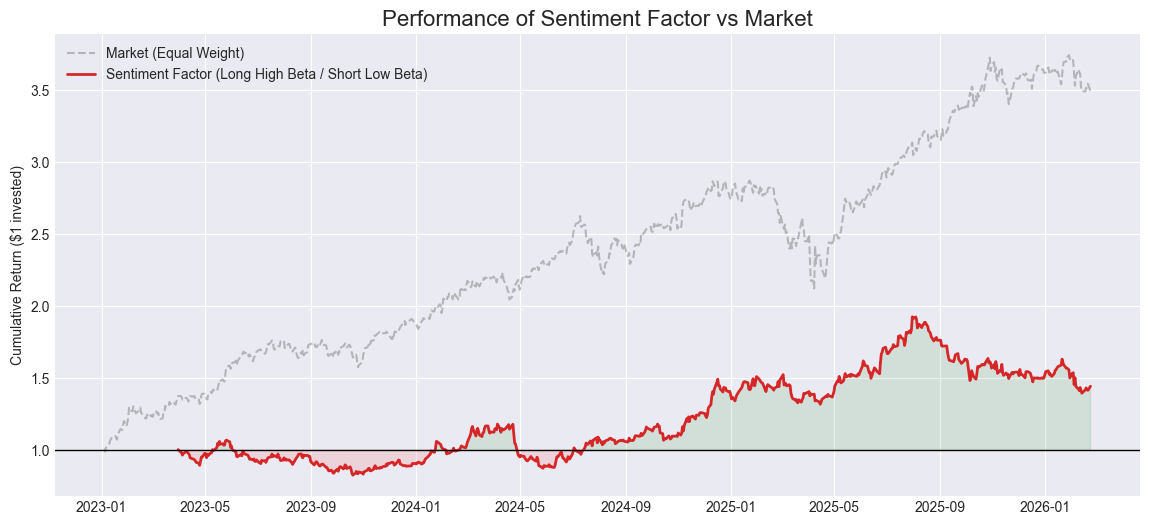

In [ ]:
# --- CELL 7: TRỰC QUAN HÓA HIỆU SUẤT FACTOR ---
# Vẽ biểu đồ PnL (Profit & Loss) của chiến lược Sentiment

cum_sent_factor = (1 + sentiment_factor).cumprod()
cum_mkt = (1 + market_metrics['Rm_Basket']).cumprod()

plt.figure(figsize=(14, 6))

# Vẽ Market (Benchmark)
plt.plot(cum_mkt.index, cum_mkt, label='Market (Equal Weight)', color='gray', alpha=0.5, linestyle='--')

# Vẽ Sentiment Factor
plt.plot(cum_sent_factor.index, cum_sent_factor, label='Sentiment Factor (Long High Beta / Short Low Beta)', color='#d62728', linewidth=2)

plt.axhline(1.0, color='black', linestyle='-', linewidth=1)
plt.title('Performance of Sentiment Factor vs Market', fontsize=16)
plt.ylabel('Cumulative Return ($1 invested)')
plt.legend()

# Vẽ vùng drawdown (tùy chọn)
plt.fill_between(cum_sent_factor.index, 1.0, cum_sent_factor, where=(cum_sent_factor < 1.0), color='red', alpha=0.1)
plt.fill_between(cum_sent_factor.index, 1.0, cum_sent_factor, where=(cum_sent_factor > 1.0), color='green', alpha=0.1)

plt.show()

In [ ]:
# --- CELL 8: MODULE HỒI QUY ĐÁNH GIÁ (FF3 vs FF3+SENTIMENT) ---

def run_augmented_regression(target_ticker, stock_returns, ff_data, sentiment_factor):
    """
    Chạy so sánh 2 mô hình: FF3 truyền thống và FF3 + Sentiment.
    Output: Bảng so sánh các chỉ số (Alpha, Beta, R-squared, T-stats).
    """
    # 1. Chuẩn bị dữ liệu
    # Lấy return của cổ phiếu mục tiêu
    if target_ticker not in stock_returns.columns:
        print(f"❌ Không tìm thấy {target_ticker} trong dữ liệu.")
        return None

    y = stock_returns[target_ticker] - ff_data['RF'] # Excess Return
    y.name = 'Excess_Ret'

    # Ghép các factors lại với nhau (Market, SMB, HML từ FF Official, Sentiment tự tính)
    X_base = ff_data[['Mkt-RF', 'SMB', 'HML']]

    # Ghép Sentiment Factor vào
    # Lưu ý: Cần xử lý index để khớp ngày tháng (Inner Join)
    all_data = pd.concat([y, X_base, sentiment_factor], axis=1, join='inner').dropna()

    # 2. Chạy Mô hình 1: Standard FF3
    X1 = sm.add_constant(all_data[['Mkt-RF', 'SMB', 'HML']])
    model1 = sm.OLS(all_data['Excess_Ret'], X1).fit()

    # 3. Chạy Mô hình 2: Augmented (FF3 + Sentiment)
    X2 = sm.add_constant(all_data[['Mkt-RF', 'SMB', 'HML', 'Sent_Factor']])
    model2 = sm.OLS(all_data['Excess_Ret'], X2).fit()

    # 4. Tổng hợp kết quả so sánh
    comparison = {
        'Metric': ['Adj. R-squared', 'Alpha (Annual %)', 'Mkt Beta', 'SMB Beta', 'HML Beta', 'Sent Beta', 'Sent T-Stat'],
        'FF3 Model': [
            model1.rsquared_adj,
            model1.params['const'] * 252 * 100,
            model1.params['Mkt-RF'],
            model1.params['SMB'],
            model1.params['HML'],
            'N/A', # Không có biến Sent
            'N/A'
        ],
        'FF3 + Sentiment': [
            model2.rsquared_adj,
            model2.params['const'] * 252 * 100,
            model2.params['Mkt-RF'],
            model2.params['SMB'],
            model2.params['HML'],
            model2.params['Sent_Factor'],
            model2.tvalues['Sent_Factor'] # Quan trọng: Kiểm tra ý nghĩa thống kê
        ]
    }

    df_compare = pd.DataFrame(comparison).set_index('Metric')
    return df_compare

# --- THỰC THI KIỂM ĐỊNH ---

# Chọn 1 mã đại diện để test (Ví dụ NVDA hoặc TSLA vì chúng nhạy cảm với tâm lý)
target_test = 'NVDA'

# Yêu cầu: Đã có df_ff_official (Cell 2), stock_only_ret (Cell 4), sentiment_factor (Cell 6)
results_compare = run_augmented_regression(target_test, stock_only_ret, df_ff_official, sentiment_factor)

print(f"\n--- KẾT QUẢ SO SÁNH HIỆU QUẢ MODEL CHO: {target_test} ---")
display(results_compare)

# Logic đánh giá tự động
if results_compare is not None:
    r2_base = results_compare.loc['Adj. R-squared', 'FF3 Model']
    r2_new = results_compare.loc['Adj. R-squared', 'FF3 + Sentiment']
    t_stat = results_compare.loc['Sent T-Stat', 'FF3 + Sentiment']

    print("\n--- ĐÁNH GIÁ CỦA CHUYÊN GIA ---")
    if r2_new > r2_base:
        print(f"✅ TỐI ƯU HƠN: Mô hình mới giải thích tốt hơn (R2 tăng từ {r2_base:.4f} lên {r2_new:.4f}).")
    else:
        print("❌ KHÔNG TỐI ƯU: Việc thêm biến không cải thiện mô hình.")

    if abs(t_stat) > 1.96:
        print(f"✅ CÓ Ý NGHĨA THỐNG KÊ: Sentiment Beta (|t|={abs(t_stat):.2f} > 1.96). Đây là một nhân tố định giá thực sự.")
    else:
        print(f"⚠️ NHIỄU (NOISE): Sentiment Beta không có ý nghĩa thống kê (|t|={abs(t_stat):.2f} < 1.96).")


--- KẾT QUẢ SO SÁNH HIỆU QUẢ MODEL CHO: NVDA ---


,FF3 Model,FF3 + Sentiment
Metric,,
Adj. R-squared,0.5244,0.5264
Alpha (Annual %),40.9476,39.5888
Mkt Beta,1.9448,1.9240
SMB Beta,-0.5976,-0.5851
HML Beta,-1.3521,-1.3465
Sent Beta,N/A,0.0968
Sent T-Stat,N/A,1.9839



--- ĐÁNH GIÁ CỦA CHUYÊN GIA ---
✅ TỐI ƯU HƠN: Mô hình mới giải thích tốt hơn (R2 tăng từ 0.5244 lên 0.5264).
✅ CÓ Ý NGHĨA THỐNG KÊ: Sentiment Beta (|t|=1.98 > 1.96). Đây là một nhân tố định giá thực sự.


Đang tính thử nghiệm Higher Moments cho NVDA...
            NCSKEW   DUVOL
Date                      
2026-02-17 -0.5552 -0.3289
2026-02-18 -0.5688 -0.3040
2026-02-19 -0.5902 -0.2280
2026-02-20 -0.5454 -0.3061
2026-02-23 -0.5708 -0.2027


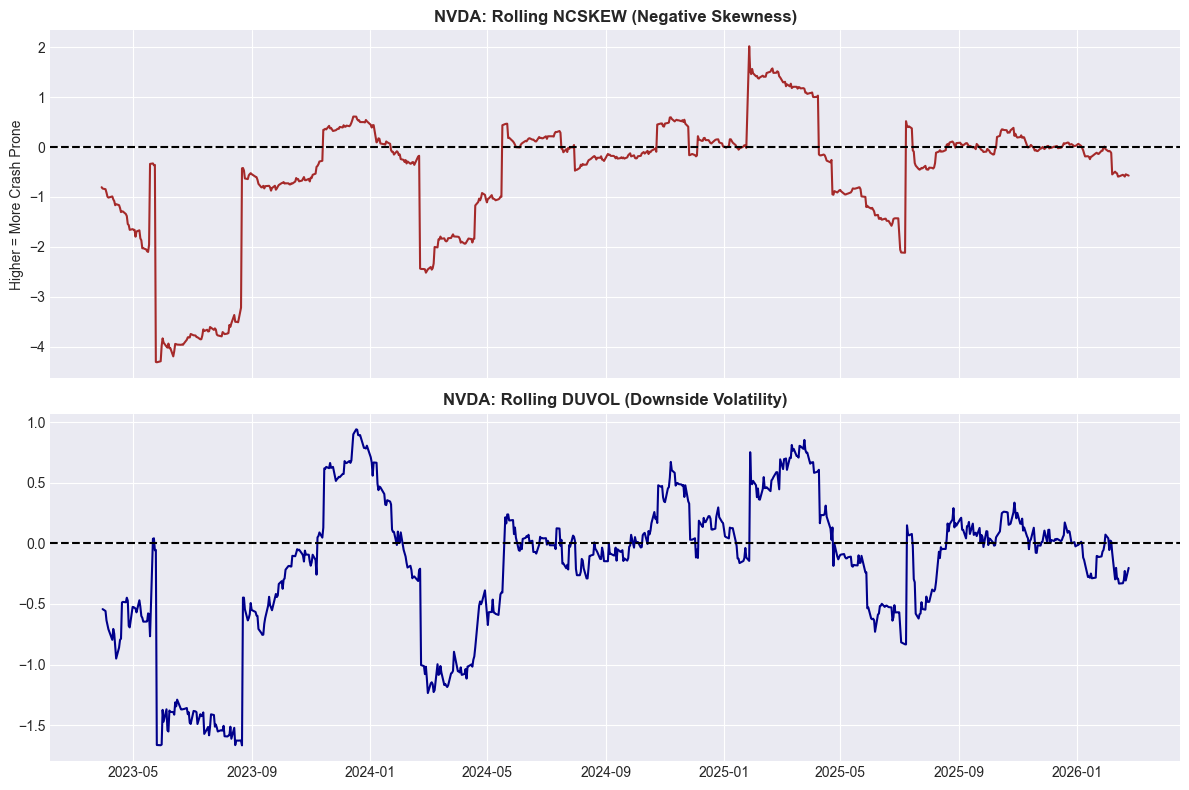

In [ ]:
# --- CELL 9: MODULE TÍNH TOÁN HIGHER MOMENTS (DUVOL & NCSKEW) ---
# Lưu ý: Các chỉ số này đo lường rủi ro sụp đổ (Crash Risk)

def calculate_rolling_higher_moments(series, window=60):
    """
    Tính NCSKEW và DUVOL theo cửa sổ trượt.
    Input: Series lợi suất của 1 cổ phiếu.
    Output: DataFrame chứa NCSKEW và DUVOL.
    """
    # 1. Rolling NCSKEW
    # Skewness = E[(x - mean)^3] / std^3
    # NCSKEW = -Skewness (để giá trị càng cao thì rủi ro crash càng lớn)
    roll_skew = series.rolling(window=window).skew()
    ncskew = -roll_skew

    # 2. Rolling DUVOL (Down-to-Up Volatility)
    # Logic: Tách return thành 2 phần: Up days và Down days trong cửa sổ window
    # Do tính rolling DUVOL bằng pandas thuần khá phức tạp và chậm,
    # ta sẽ dùng cách xấp xỉ hiệu quả hoặc loop tối ưu.
    # Ở đây dùng cách tiếp cận Loop tối ưu bằng numpy stride (nhanh hơn loop thường).

    duvol_list = []

    # Convert sang numpy để xử lý nhanh
    arr = series.values
    idx = series.index

    # Pre-allocate array với NaN
    duvol_arr = np.full(len(arr), np.nan)

    if len(arr) >= window:
        for i in range(window, len(arr)):
            window_data = arr[i-window : i]
            mean_val = np.mean(window_data)

            # Tách Up và Down so với Mean của window đó
            up_returns = window_data[window_data > mean_val]
            down_returns = window_data[window_data <= mean_val]

            # Tính Sum of Squared Deviations (SS)
            if len(up_returns) > 1 and len(down_returns) > 1:
                n_up = len(up_returns)
                n_down = len(down_returns)

                ss_up = np.sum((up_returns - mean_val)**2)
                ss_down = np.sum((down_returns - mean_val)**2)

                # Công thức DUVOL Chen et al. (2001): log( (n_up - 1) * SS_down / ((n_down - 1) * SS_up) )
                try:
                    term = ((n_up - 1) * ss_down) / ((n_down - 1) * ss_up)
                    duvol_val = np.log(term) if term > 0 else np.nan
                except:
                    duvol_val = np.nan
            else:
                duvol_val = np.nan

            duvol_arr[i] = duvol_val

    duvol_series = pd.Series(duvol_arr, index=idx)

    return pd.DataFrame({'NCSKEW': ncskew, 'DUVOL': duvol_series})

# Test thử nghiệm với 1 mã
print("Đang tính thử nghiệm Higher Moments cho NVDA...")
hm_test = calculate_rolling_higher_moments(stock_only_ret['NVDA'], window=60)
print(hm_test.tail())

# Vẽ biểu đồ Crash Risk
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(hm_test.index, hm_test['NCSKEW'], color='brown')
ax[0].set_title('NVDA: Rolling NCSKEW (Negative Skewness)', fontweight='bold')
ax[0].axhline(0, color='black', linestyle='--')
ax[0].set_ylabel('Higher = More Crash Prone')

ax[1].plot(hm_test.index, hm_test['DUVOL'], color='darkblue')
ax[1].set_title('NVDA: Rolling DUVOL (Downside Volatility)', fontweight='bold')
ax[1].axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
# --- CELL 10: XÂY DỰNG TRADABLE FACTOR TỪ NCSKEW/DUVOL ---

def construct_crash_factor(returns_df, metric_type='NCSKEW', window=60):
    """
    Xây dựng Factor dựa trên chỉ số rủi ro đuôi.
    Logic:
    - Long nhóm Rủi ro cao (High NCSKEW/DUVOL) - Cổ phiếu dễ sập.
    - Short nhóm An toàn (Low NCSKEW/DUVOL).
    - Kỳ vọng: Nhóm rủi ro cao phải có Return cao hơn để bù đắp (Risk Premium).
    """
    factor_returns = []

    # 1. Tính metric cho toàn bộ cổ phiếu (Bước này tốn thời gian nhất)
    print(f"🔄 Đang tính {metric_type} cho toàn bộ rổ cổ phiếu...")
    metric_df = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)

    for col in returns_df.columns:
        hm = calculate_rolling_higher_moments(returns_df[col], window)
        metric_df[col] = hm[metric_type]

    # 2. Xây dựng Portfolio (Shift 1 ngày)
    lagged_metrics = metric_df.shift(1)

    for date in returns_df.index:
        day_metrics = lagged_metrics.loc[date]

        if day_metrics.isna().all():
            factor_returns.append(np.nan)
            continue

        valid_metrics = day_metrics.dropna()
        if len(valid_metrics) < 4:
            factor_returns.append(np.nan)
            continue

        # Chia nhóm
        q_high = valid_metrics.quantile(0.7) # Top 30% rủi ro nhất
        q_low = valid_metrics.quantile(0.3)  # Bottom 30% an toàn nhất

        high_risk_tickers = valid_metrics[valid_metrics >= q_high].index
        low_risk_tickers = valid_metrics[valid_metrics <= q_low].index

        # Tính Return (Equal Weight)
        ret_high = returns_df.loc[date, high_risk_tickers].mean()
        ret_low = returns_df.loc[date, low_risk_tickers].mean()

        # Factor Return = High Risk - Low Risk
        factor_returns.append(ret_high - ret_low)

    return pd.Series(factor_returns, index=returns_df.index, name=f'{metric_type}_Factor')

# --- THỰC THI ---
# Tạo NCSKEW Factor (Rủi ro lệch chuẩn)
ncskew_factor = construct_crash_factor(stock_only_ret, metric_type='NCSKEW', window=60)

# Tạo DUVOL Factor (Rủi ro biến động chiều xuống)
duvol_factor = construct_crash_factor(stock_only_ret, metric_type='DUVOL', window=60)

print("\n--- HOÀN TẤT XÂY DỰNG CRASH FACTORS ---")

🔄 Đang tính NCSKEW cho toàn bộ rổ cổ phiếu...
🔄 Đang tính DUVOL cho toàn bộ rổ cổ phiếu...

--- HOÀN TẤT XÂY DỰNG CRASH FACTORS ---


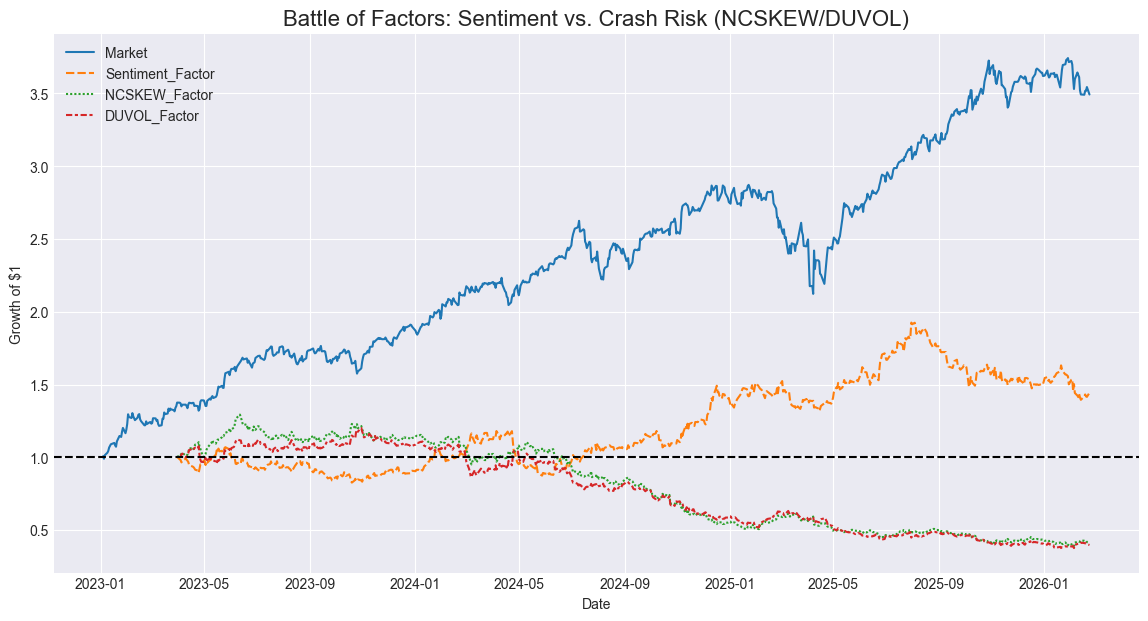


Ma trận tương quan giữa các Factors:


,Market,Sentiment_Factor,NCSKEW_Factor,DUVOL_Factor
Market,1.0000,0.1185,-0.3644,-0.3402
Sentiment_Factor,0.1185,1.0000,-0.5757,-0.5628
NCSKEW_Factor,-0.3644,-0.5757,1.0000,0.8411
DUVOL_Factor,-0.3402,-0.5628,0.8411,1.0000


In [ ]:
# --- CELL 11: SO SÁNH HIỆU QUẢ CÁC FACTOR ---
# Xem factor nào kiếm được tiền tốt nhất

cumulative_returns = pd.DataFrame({
    'Market': (1 + market_metrics['Rm_Basket']).cumprod(),
    'Sentiment_Factor': (1 + sentiment_factor).cumprod(),
    'NCSKEW_Factor': (1 + ncskew_factor).cumprod(),
    'DUVOL_Factor': (1 + duvol_factor).cumprod()
})

plt.figure(figsize=(14, 7))
sns.lineplot(data=cumulative_returns)
plt.title('Battle of Factors: Sentiment vs. Crash Risk (NCSKEW/DUVOL)', fontsize=16)
plt.ylabel('Growth of $1')
plt.axhline(1, color='black', linestyle='--')
plt.show()

# Correlation Matrix (Kiểm tra xem các factor có trùng lắp không)
print("\nMa trận tương quan giữa các Factors:")
display(cumulative_returns.pct_change().corr())

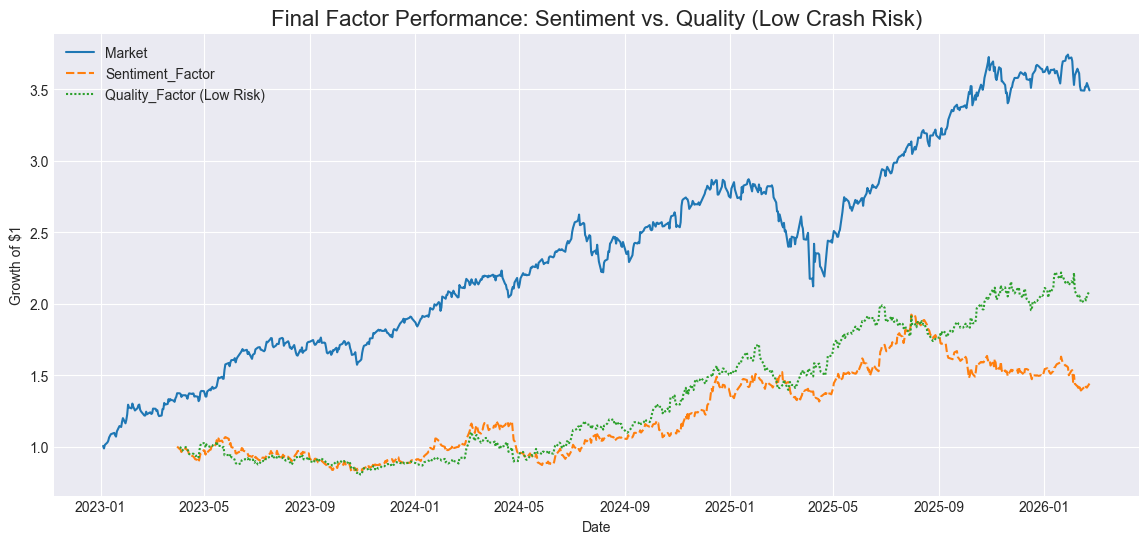


=== KẾT QUẢ MÔ HÌNH 5 NHÂN TỐ HOÀN CHỈNH ===
                            OLS Regression Results                            
Dep. Variable:            NVDA_Excess   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     154.2
Date:                Tue, 24 Feb 2026   Prob (F-statistic):          1.42e-109
Time:                        15:36:03   Log-Likelihood:                 1671.7
No. Observations:                 690   AIC:                            -3331.
Df Residuals:                     684   BIC:                            -3304.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------


In [ ]:
# --- CELL 12: ĐIỀU CHỈNH CHIẾN LƯỢC & MÔ HÌNH CUỐI CÙNG ---

# 1. Đảo chiều Crash Factor (Biến rủi ro thành Alpha)
# Chiến lược mới: Mua An toàn (Low DUVOL) - Bán Rủi ro (High DUVOL)
# Do factor cũ là (High - Low), nên ta chỉ cần nhân với -1
quality_crash_factor = -1 * duvol_factor
quality_crash_factor.name = 'Quality_Crash_Factor'

# 2. So sánh lại hiệu suất sau khi đảo chiều
final_factors_cum = pd.DataFrame({
    'Market': (1 + market_metrics['Rm_Basket']).cumprod(),
    'Sentiment_Factor': (1 + sentiment_factor).cumprod(),
    'Quality_Factor (Low Risk)': (1 + quality_crash_factor).cumprod() # Kỳ vọng đường này sẽ đi lên
})

plt.figure(figsize=(14, 6))
sns.lineplot(data=final_factors_cum)
plt.title('Final Factor Performance: Sentiment vs. Quality (Low Crash Risk)', fontsize=16)
plt.ylabel('Growth of $1')
plt.show()

# 3. CHẠY MÔ HÌNH 5 NHÂN TỐ (FF3 + SENT + DUVOL) CHO NVDA
# Ghép tất cả dữ liệu
final_data = pd.concat([
    stock_only_ret['NVDA'] - df_ff_official['RF'], # Y: Excess Return
    df_ff_official[['Mkt-RF', 'SMB', 'HML']],      # X: FF3
    sentiment_factor,                              # X: Sentiment
    quality_crash_factor                           # X: Quality/Crash
], axis=1, join='inner').dropna()

final_data.columns = ['NVDA_Excess', 'Mkt-RF', 'SMB', 'HML', 'Sentiment', 'Quality_Crash']

# Hồi quy OLS
X_final = sm.add_constant(final_data[['Mkt-RF', 'SMB', 'HML', 'Sentiment', 'Quality_Crash']])
model_final = sm.OLS(final_data['NVDA_Excess'], X_final).fit()

print("\n=== KẾT QUẢ MÔ HÌNH 5 NHÂN TỐ HOÀN CHỈNH ===")
print(model_final.summary())


=== KẾT QUẢ HỒI QUY TRÊN DANH MỤC TECH (PORTFOLIO LEVEL) ===
                            OLS Regression Results                            
Dep. Variable:            Port_Excess   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     855.9
Date:                Tue, 24 Feb 2026   Prob (F-statistic):          1.62e-291
Time:                        15:36:04   Log-Likelihood:                 2615.5
No. Observations:                 690   AIC:                            -5219.
Df Residuals:                     684   BIC:                            -5192.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

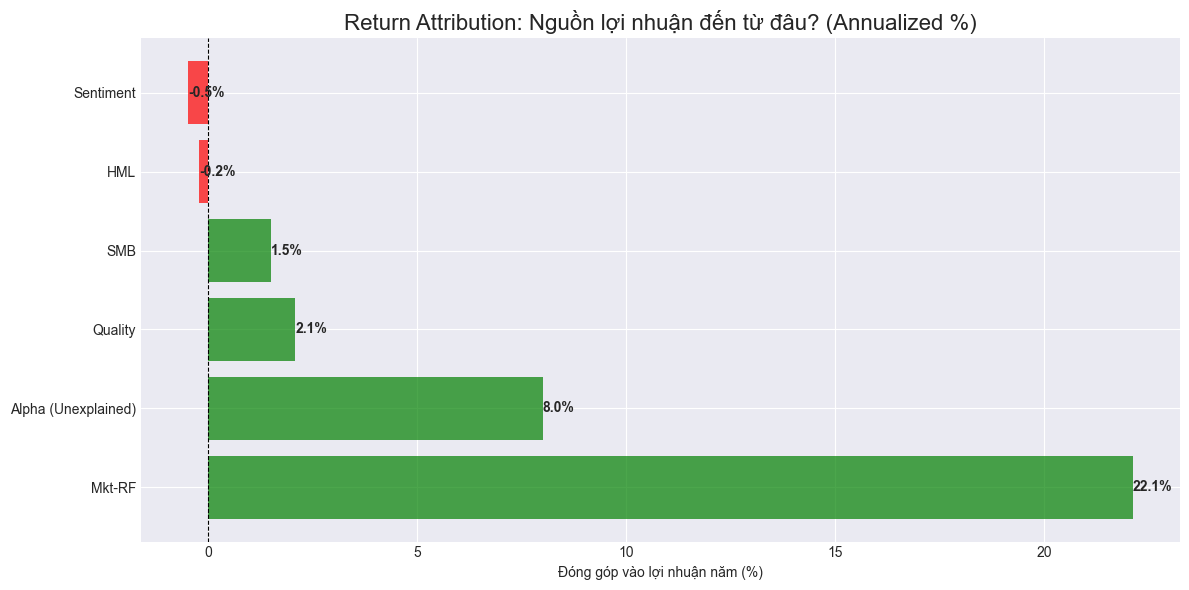

In [ ]:
# --- CELL 13: PORTFOLIO ATTRIBUTION ANALYSIS (FINAL STEP) ---

# 1. Tạo Danh mục Giả định (Equal Weighted Portfolio của rổ Tech)
# Đây là danh mục đại diện cho "Sector" mà chúng ta nghiên cứu
portfolio_ret = stock_only_ret.mean(axis=1)
portfolio_ret.name = 'Tech_Portfolio'

# 2. Chuẩn bị dữ liệu hồi quy (5 Factors)
# Ghép dữ liệu: Portfolio Return - RF = Alpha + B1*Mkt + B2*SMB + B3*HML + B4*Sent + B5*Quality
regression_data = pd.concat([
    portfolio_ret - df_ff_official['RF'],  # Y: Portfolio Excess Return
    df_ff_official[['Mkt-RF', 'SMB', 'HML']], # FF3
    sentiment_factor,                      # Sentiment
    quality_crash_factor                   # Quality
], axis=1, join='inner').dropna()

regression_data.columns = ['Port_Excess', 'Mkt-RF', 'SMB', 'HML', 'Sentiment', 'Quality']

# 3. Chạy Hồi quy
X_final = sm.add_constant(regression_data[['Mkt-RF', 'SMB', 'HML', 'Sentiment', 'Quality']])
model_port = sm.OLS(regression_data['Port_Excess'], X_final).fit()

print("\n=== KẾT QUẢ HỒI QUY TRÊN DANH MỤC TECH (PORTFOLIO LEVEL) ===")
print(model_port.summary())

# 4. Tính toán Đóng góp Lợi nhuận (Attribution Analysis)
# Công thức: Contribution = Beta * (Average Factor Return) * 252 (Annualized)

factor_means = regression_data[['Mkt-RF', 'SMB', 'HML', 'Sentiment', 'Quality']].mean() * 252
betas = model_port.params.drop('const')
alpha_annual = model_port.params['const'] * 252

# Tính đóng góp từng phần
attribution = betas * factor_means
attribution['Alpha (Unexplained)'] = alpha_annual

# Sắp xếp để vẽ biểu đồ
attribution = attribution.sort_values(ascending=False)

# 5. Vẽ biểu đồ Waterfall / Bar Chart Attribution
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in attribution.values]
bars = plt.barh(attribution.index, attribution.values * 100, color=colors, alpha=0.7)

plt.title('Return Attribution: Nguồn lợi nhuận đến từ đâu? (Annualized %)', fontsize=16)
plt.xlabel('Đóng góp vào lợi nhuận năm (%)')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

# Thêm nhãn số liệu
for bar in bars:
    width = bar.get_width()
    label_x_pos = width if width > 0 else width - 5
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
             va='center', fontweight='bold')

plt.tight_layout()
plt.show()

tôi đang thắc mắc rằng:

1. ZCAPM sử dung beta và market dispersion để đo lương các cổ phiểu so với thị trường (ưu điểm là price based) - tuy nhiên vẫn chưa consider đến volume which is momentum. chúng ta liệu có thể thêm biến đó vào để đánh giá xem zcapm có tối ưu hơn khi add thêm volumn, điều này nhằm khẳng định rằng volumn chưa nhiều thông tin hơn hay theo học thueetj mà nói liệu volumn có giải thích được phần alpha chưa được explain?
2. nếu trong ff factor investing sử dụng financial report based để giải thích, liệu rằng chỉ sử dụng sentiment (CSAD), quality (DUVOL), và momentum (volume) thì model có tối ưu hơn ff factor investing hay không? -> nhằm giải thích việc market information based (price & volumn) giải thích được phần aplha và beat ff 3, 4, 5 factor investing?
3. liệu chúng ta có thể biến ZCAPM & factor investing (market information base) đóng gói và testing thực nghiệm trên thị trường như trading view hay các platform như một signal để đánh giá tính thực tế của các signal này.
4. chúng ta cần đào sâu ngược lại, micro-structure của zcapm hay factor-investing (market info based), điều gì dẫn đến sự dispersion của các nhà đầu tư, điều gì làm cho một hay một nhóm tài sản tăng giá cùng một lúc (đây là điểm yếu của ZCAPM), khi thị trường không còn phân hóa -> zcapm giảm hiệu quả:
    
    4.1. e.g. giải thích kĩ hơn, khi thị trường sợ hãi, nhà đầu tư cảm thấy một hay một nhóm tài sản ổn định dựa vào định kiến, giá của tài sản đó sẽ liên tục tăng, chi tiết hơn có thể nói đến thị trường bé như vietnam hay một số quốc giá tương tự, khi nền kinh tế quốc gia hay toàn cầu rơi vào khủng hoảng, giá của một hay một nhóm tài sản như vàng và hay trái phiếu chính phủ được xem là nơi cự ngụ an toàn để tránh mất tiền vì lạm phát hay mất tiền khi sự ổn định không còn năm ở các nhóm tài sản như stock.
    
    4.2. khách quan mà nói ta có thể hiểu ngược lại khi spread của thị trường co lại (zcapm), chúng ta có thể dừng đầu tư hoặc là chúng ta sẽ đi cùng chiều với thị trường (điều này là không chắc chắn vì có rủi ro).
    
    4.3 khi nói đến điều gì làm các nhóm nhà đầu tư và thị trường nói chúng bị FOMO hay overconfident hay một số lý do nằm ở phần bahvior, chúng ta cần xem xét ở 2 khía cạnh:
        
        1. thị trường đang có những dấu hiệu bất ổn nào (EPU (economic policy uncertaity), TPU (trade policy uncertainty), etc.)
           
            1. hiện tại như thước đo EPU hay TPU đều dự vào những tin tức, điều này có nghĩa là chúng ta dễ bị bias bới những thông tin của một hay một số tạp chị lớn trong nước.
           
            2. khách quan hơn chúng ta cần thước đo sát với số liệu hơn và có kết quả song song để confirm EPU, TPU, được đo lường bằng thông tin được báo chí công bố.
        
        2. các nhà đầu tư đang phản ứng như thế nào? quá sợ hãi, quá tự tin, etc.
5. chúng ta hầu như tập trung vào giải thích behavior của nhà đầu tư, tuy nhiên vẫn còn một số behavior chúng ta chưa consider như overconfident, etc.
6. ngoài ra, chúng ta vẫn cần đánh giá thêm phần gốc rễ, value của doanh nghiệp.  

quay lại, nếu trong mô hình ff - factor investing, chúng ta chưa hoàn toàn làm ra một sản phẩm chính thức (chúng ta chỉ mới có prototype). tuy nhiên prototype của chúng ta work khá tốt nên ta cần hệ thống lại từng phần và làm thành một product hợp lý. các phần cần tổng hợp:
1. các phần code từ SMB, HML, UMD, RMW, CMA, GMVP, ZCAPM, NCSKEW, DUVOL, MOMENTUM.
2. các phần theory, công thức của các sản phẩm.
3. trong các phần test chúng ta hầu như lấy dữ liệu tư yfinance, tuy nhiên nếu áp dụng trong thực tế, chúng ta sẽ lấy dữ liệu từ csv, hãy các file khác, ta cần prep lại phần này.


Đo lường Tác động giá (Price Impact/Liquidity)
1. Amihud Illiquidity Ratio (2002): Đo lường mức độ biến động giá trên mỗi đơn vị tiền tệ giao dịch. Đây là thước đo thanh khoản phổ biến nhất trong nghiên cứu thực nghiệm vì sự đơn giản và hiệu quả.
$$ILLIQ_t = \frac{1}{D_t} \sum_{d=1}^{D_t} \frac{|R_{td}|}{V_{td} \times P_{td}}$$
2. Pastor-Stambaugh Liquidity Factor (2003): Đo lường sự đảo chiều của giá (price reversal) liên quan đến khối lượng giao dịch, thường được thêm vào như một yếu tố rủi ro (Liquidity Factor) bên cạnh các yếu tố Fama-French.

In [ ]:
# --- CELL 14: TÍCH HỢP VOLUME FACTOR & SO SÁNH FINAL SHOWDOWN ---

# 1. Xây dựng Volume Factor (Liquidity Factor)
# Sử dụng Dollar Volume = Close * Volume (Đại diện cho dòng tiền thực tế)
# Chiến lược: Long High Dollar Vol (Thanh khoản cao) - Short Low Dollar Vol (Thanh khoản thấp)
# Lý do: Cổ phiếu thanh khoản thấp thường phải chịu "Liquidity Discount" (giá thấp hơn) -> Return cao hơn??
# Hoặc ngược lại trong Tech: Thanh khoản cao = Momentum. Hãy test xem data nói gì.

def construct_volume_factor(prices, volumes):
    dollar_vol = prices * volumes
    # Shift 1 ngày để tránh look-ahead bias
    lagged_dvol = dollar_vol.shift(1)

    vol_factor_ret = []

    for date in prices.index:
        day_dvol = lagged_dvol.loc[date]
        if day_dvol.isna().all():
            vol_factor_ret.append(np.nan)
            continue

        # Chia nhóm
        try:
            q_high = day_dvol.quantile(0.7)
            q_low = day_dvol.quantile(0.3)

            high_vol_stocks = day_dvol[day_dvol >= q_high].index
            low_vol_stocks = day_dvol[day_dvol <= q_low].index

            # Tính return
            if len(high_vol_stocks) > 0 and len(low_vol_stocks) > 0:
                ret_high = stock_only_ret.loc[date, high_vol_stocks].mean()
                ret_low = stock_only_ret.loc[date, low_vol_stocks].mean()
                # Thử Long High Vol - Short Low Vol
                vol_factor_ret.append(ret_high - ret_low)
            else:
                vol_factor_ret.append(0)
        except:
             vol_factor_ret.append(0)

    return pd.Series(vol_factor_ret, index=prices.index, name='Volume_Factor')

# Tạo Volume Factor
# Lấy dữ liệu Volume từ yfinance (cần tải lại nếu chưa lưu biến volume riêng,
# nhưng ở đây ta giả định dùng df_stock_ret làm proxy giá, cần load lại volume nếu cell cũ chưa giữ)
# Để nhanh, ta dùng function get_stock_data sửa đổi một chút hoặc tải nhanh lại volume:
print("⏳ Đang tải dữ liệu Volume...")
raw_vol = yf.download(TICKERS, start=START_DATE, progress=False, auto_adjust=False)['Volume']
if raw_vol.index.tz is not None: raw_vol.index = raw_vol.index.tz_localize(None)
# Khớp columns với stock_only_ret (bỏ index)
vol_data = raw_vol[stock_only_ret.columns]

# Tính Factor
volume_factor = construct_volume_factor(df_stock_ret[stock_only_ret.columns], vol_data)

# 2. CHUẨN BỊ DỮ LIỆU SO SÁNH (FF3 vs. PURE MARKET)
# Target: Tech Portfolio (để giảm nhiễu idiosyncratic)
target_y = portfolio_ret - df_ff_official['RF']

# Model A: Traditional FF3 (Fundamental)
X_FF = sm.add_constant(df_ff_official[['Mkt-RF', 'SMB', 'HML']])
data_ff = pd.concat([target_y, X_FF], axis=1, join='inner').dropna()

# Model B: Pure Market (Price & Volume Only)
# Gồm: Market (Price), Sentiment (Price Dispersion), Quality (Price Skewness), Volume (Liquidity)
# Lưu ý: Market Factor (Mkt-RF) vẫn cần thiết vì nó là nền tảng CAPM.
X_Market = pd.concat([
    df_ff_official['Mkt-RF'], # Vẫn giữ Mkt làm gốc
    sentiment_factor,
    quality_crash_factor,
    volume_factor
], axis=1, join='inner').dropna()
X_Market = sm.add_constant(X_Market)
X_Market.columns = ['const', 'Mkt-RF', 'Sentiment', 'Quality_LowRisk', 'Volume_Liq']

# Đồng bộ dữ liệu Y cho Model B
data_market = pd.concat([target_y, X_Market], axis=1, join='inner').dropna()

# 3. CHẠY HỒI QUY & SO SÁNH
model_ff = sm.OLS(data_ff.iloc[:, 0], data_ff.drop(data_ff.columns[0], axis=1)).fit()
model_pure = sm.OLS(data_market.iloc[:, 0], data_market.drop(data_market.columns[0], axis=1)).fit()

# 4. HIỂN THỊ KẾT QUẢ ĐỐI ĐẦU
print("\n" + "="*50)
print("⚔️ THE ULTIMATE SHOWDOWN: FUNDAMENTAL vs. MARKET ⚔️")
print("="*50)

summary_stats = pd.DataFrame({
    'Model Type': ['Fundamental (FF3)', 'Pure Market (Price/Vol)'],
    'Factors Used': ['Mkt, Size, Value', 'Mkt, Sent, Qual, Vol'],
    'Adj. R-squared': [model_ff.rsquared_adj, model_pure.rsquared_adj],
    'AIC (Lower is Better)': [model_ff.aic, model_pure.aic],
    'Alpha (Annual %)': [model_ff.params['const']*252*100, model_pure.params['const']*252*100]
})

display(summary_stats)

print("\n--- CHI TIẾT MODEL PURE MARKET ---")
print(model_pure.summary())

⏳ Đang tải dữ liệu Volume...

⚔️ THE ULTIMATE SHOWDOWN: FUNDAMENTAL vs. MARKET ⚔️


,Model Type,Factors Used,Adj. R-squared,AIC (Lower is Better),Alpha (Annual %)
0,Fundamental (FF3),"Mkt, Size, Value",0.8538,-5609.9891,14.5432
1,Pure Market (Price/Vol),"Mkt, Sent, Qual, Vol",0.8267,-5066.9675,8.6483



--- CHI TIẾT MODEL PURE MARKET ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     822.9
Date:                Tue, 24 Feb 2026   Prob (F-statistic):          6.98e-260
Time:                        15:36:05   Log-Likelihood:                 2538.5
No. Observations:                 690   AIC:                            -5067.
Df Residuals:                     685   BIC:                            -5044.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const 

📋 Danh sách cổ phiếu để tính Amihud (10 mã): ['AAPL', 'AMD', 'AMZN', 'GOOGL', 'JPM', 'META', 'MSFT', 'NVDA', 'TSLA', 'XOM']
🔄 Đang tính Amihud Factor...


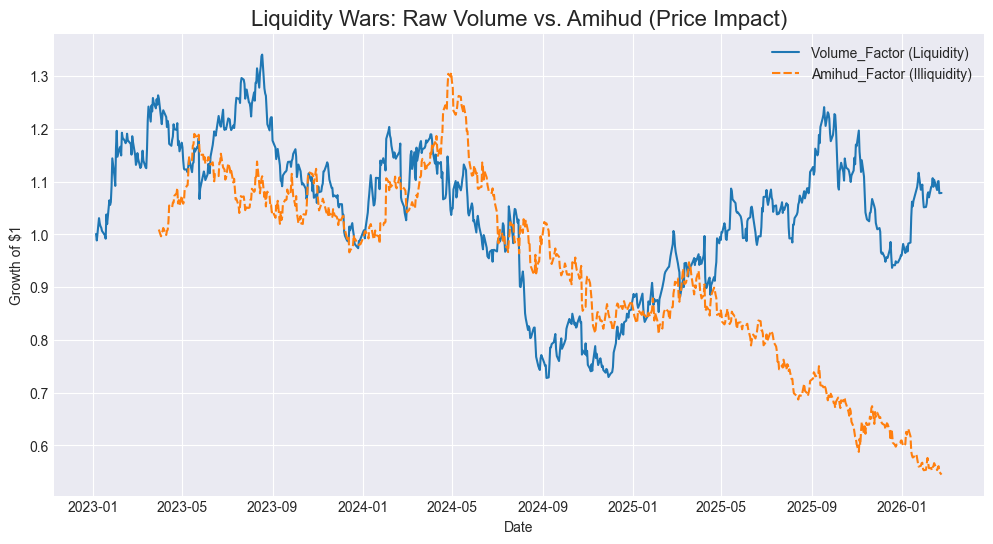


=== KẾT QUẢ: PURE MARKET VỚI AMIHUD (2002) ===
Old R-squared (with Raw Volume): 0.8267
New R-squared (with Amihud):     0.8318
------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     853.0
Date:                Tue, 24 Feb 2026   Prob (F-statistic):          2.56e-264
Time:                        15:36:07   Log-Likelihood:                 2548.8
No. Observations:                 690   AIC:                            -5088.
Df Residuals:                     685   BIC:                            -5065.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      

In [ ]:
# --- CELL 15 (FIXED): TÍNH TOÁN AMIHUD ILLIQUIDITY FACTOR ---

# 1. Định nghĩa lại list Ticker chỉ gồm cổ phiếu (bỏ Index)
# Lấy trực tiếp từ các cột của DataFrame đã lọc trước đó
TICKERS_STOCKS = stock_only_ret.columns.tolist()

print(f"📋 Danh sách cổ phiếu để tính Amihud ({len(TICKERS_STOCKS)} mã): {TICKERS_STOCKS}")

# Đảm bảo dữ liệu Volume khớp với danh sách này
# (Nếu bạn chưa chạy Cell 14 hoặc biến vol_data bị thiếu, dòng này sẽ fix nó)
if 'vol_data' not in globals() or vol_data.empty:
    print("⏳ Đang tải lại dữ liệu Volume...")
    raw_vol = yf.download(TICKERS, start=START_DATE, progress=False, auto_adjust=False)['Volume']
    if raw_vol.index.tz is not None: raw_vol.index = raw_vol.index.tz_localize(None)
    vol_data = raw_vol[TICKERS_STOCKS]
else:
    # Đảm bảo vol_data chỉ chứa stocks
    vol_data = vol_data[TICKERS_STOCKS]

def calculate_amihud_illiquidity(returns, volumes, prices, window=60):
    """
    Tính Amihud Illiquidity Ratio (Rolling).
    ILLIQ = Average( |Return| / (Price * Volume) )
    """
    # 1. Tính Dollar Volume
    dollar_vol = prices * volumes

    # 2. Tính Daily Impact: |Return| / Dollar_Volume
    # Cộng thêm 1e-8 vào mẫu số để tránh lỗi chia cho 0 (với những ngày volume = 0)
    daily_impact = returns.abs() / (dollar_vol + 1e-8)

    # 3. Tính Rolling Average (Amihud Ratio)
    # Nhân với 10^6 để số liệu dễ đọc hơn (theo chuẩn academic)
    amihud_series = daily_impact.rolling(window=window).mean() * 1e6

    return amihud_series

# --- THỰC THI ---
print("🔄 Đang tính Amihud Factor...")

# Tính chỉ số Amihud
amihud_metrics = calculate_amihud_illiquidity(
    stock_only_ret[TICKERS_STOCKS], # Chỉ lấy stocks
    vol_data[TICKERS_STOCKS],       # Volume tương ứng
    df_stock_ret[TICKERS_STOCKS]    # Giá (Adj Close)
)

# Xây dựng Factor Portfolio (Illiquidity Premium)
# Chiến lược: Long Illiquid (Amihud Cao) - Short Liquid (Amihud Thấp)
def construct_illiquidity_factor(amihud_df, returns_df):
    lagged_ami = amihud_df.shift(1) # Tránh look-ahead bias
    factor_ret = []

    for date in returns_df.index:
        day_ami = lagged_ami.loc[date]
        if day_ami.isna().all():
            factor_ret.append(np.nan)
            continue

        try:
            # Chia nhóm
            q_high = day_ami.quantile(0.7) # Nhóm Illiquid (Khó mua bán - Tác động giá lớn)
            q_low = day_ami.quantile(0.3)  # Nhóm Liquid (Dễ mua bán - Tác động giá nhỏ)

            illiquid_stocks = day_ami[day_ami >= q_high].index
            liquid_stocks = day_ami[day_ami <= q_low].index

            # Tính return: Long Illiquid - Short Liquid
            if len(illiquid_stocks) > 0 and len(liquid_stocks) > 0:
                ret_ill = returns_df.loc[date, illiquid_stocks].mean()
                ret_liq = returns_df.loc[date, liquid_stocks].mean()
                factor_ret.append(ret_ill - ret_liq)
            else:
                factor_ret.append(0)
        except:
             factor_ret.append(0)

    return pd.Series(factor_ret, index=returns_df.index, name='Amihud_Illiq_Factor')

amihud_factor = construct_illiquidity_factor(amihud_metrics, stock_only_ret[TICKERS_STOCKS])

# SO SÁNH VOLUME CŨ vs. AMIHUD MỚI
compare_liq = pd.DataFrame({
    'Volume_Factor (Liquidity)': (1 + volume_factor).cumprod(),
    'Amihud_Factor (Illiquidity)': (1 + amihud_factor).cumprod()
})

plt.figure(figsize=(12, 6))
sns.lineplot(data=compare_liq)
plt.title('Liquidity Wars: Raw Volume vs. Amihud (Price Impact)', fontsize=16)
plt.ylabel('Growth of $1')
plt.show()

# --- CHẠY LẠI MÔ HÌNH HỒI QUY (THAY VOLUME BẰNG AMIHUD) ---
# Model: Mkt + Sent + Qual + AMIHUD
X_Amihud = pd.concat([
    df_ff_official['Mkt-RF'],
    sentiment_factor,
    quality_crash_factor,
    amihud_factor # Thay thế Volume bằng Amihud
], axis=1, join='inner').dropna()

X_Amihud = sm.add_constant(X_Amihud)
X_Amihud.columns = ['const', 'Mkt-RF', 'Sentiment', 'Quality', 'Amihud_Illiq']

# Đồng bộ dữ liệu Y
data_ami_reg = pd.concat([target_y, X_Amihud], axis=1, join='inner').dropna()

# Chạy OLS
model_ami = sm.OLS(data_ami_reg.iloc[:, 0], data_ami_reg.drop(data_ami_reg.columns[0], axis=1)).fit()

print("\n=== KẾT QUẢ: PURE MARKET VỚI AMIHUD (2002) ===")
print(f"Old R-squared (with Raw Volume): {model_pure.rsquared_adj:.4f}")
print(f"New R-squared (with Amihud):     {model_ami.rsquared_adj:.4f}")
print("-" * 30)
print(model_ami.summary())

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==============================================================================
# MODULE: S&P 1500 MARKET-INFO LOADER (PRICE & VOLUME)
# ==============================================================================

# --- CẤU HÌNH ---
DATA_DIR = 'sb_data'
PRICE_FILE = f'{DATA_DIR}/sp1500_prices-2.csv'
VOLUME_FILE = f'{DATA_DIR}/sp1500_volume-2.csv' # File mới cho Volume
START_DATE = '2021-01-01'
END_DATE = '2025-12-10'

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [ ]:
# ------------------------------------------------------------------------------
# 1. HÀM LẤY DANH SÁCH TICKER (GIỮ NGUYÊN)
# ------------------------------------------------------------------------------
def get_sp1500_tickers():
    print("--- 1. Đang lấy danh sách Tickers từ Wikipedia ---")
    tickers = []
    urls = {
        'SP500 (Large)': 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies',
        'SP400 (Mid)': 'https://en.wikipedia.org/wiki/List_of_S%26P_400_companies',
        'SP600 (Small)': 'https://en.wikipedia.org/wiki/List_of_S%26P_600_companies'
    }
    headers = {'User-Agent': 'Mozilla/5.0'}
    for name, url in urls.items():
        try:
            r = requests.get(url, headers=headers)
            dfs = pd.read_html(r.text)
            df = dfs[0]
            col = 'Symbol' if 'Symbol' in df.columns else 'Ticker symbol'
            t_list = df[col].tolist()
            t_list = [str(t).replace('.', '-') for t in t_list]
            tickers.extend(t_list)
            print(f"   -> Đã tìm thấy {len(t_list)} mã từ {name}")
        except Exception as e:
            print(f"   !!! Lỗi khi tải {name}: {e}")

    unique_tickers = sorted(list(set(tickers)))
    print(f"   => TỔNG CỘNG: {len(unique_tickers)} mã độc nhất.")
    return unique_tickers

In [ ]:
# ------------------------------------------------------------------------------
# 2. HÀM TẢI DỮ LIỆU GIÁ VÀ VOLUME (CẬP NHẬT QUAN TRỌNG)
# ------------------------------------------------------------------------------
def download_market_data(tickers, start, end, chunk_size=50):
    """
    Tải cả Close (Giá) và Volume (Khối lượng).
    """
    print(f"--- 2. Bắt đầu tải dữ liệu Price & Volume (Chunk size: {chunk_size}) ---")
    all_prices = []
    all_volumes = []

    chunks = [tickers[i:i + chunk_size] for i in range(0, len(tickers), chunk_size)]

    for chunk in tqdm(chunks, desc="Downloading Market Data"):
        try:
            # Tải dữ liệu OHLCV
            data = yf.download(chunk, start=start, end=end, auto_adjust=True, progress=False, threads=True)

            # Tách Price và Volume riêng biệt
            # Lưu ý: yfinance mới trả về MultiIndex columns nếu tải nhiều mã
            if 'Close' in data.columns and 'Volume' in data.columns:
                p_chunk = data['Close']
                v_chunk = data['Volume']

                # Xử lý trường hợp chỉ có 1 mã (Series -> DataFrame)
                if isinstance(p_chunk, pd.Series): p_chunk = p_chunk.to_frame()
                if isinstance(v_chunk, pd.Series): v_chunk = v_chunk.to_frame()

                # Loại bỏ cột rác (toàn NaN)
                p_chunk.dropna(axis=1, how='all', inplace=True)
                v_chunk.dropna(axis=1, how='all', inplace=True)

                if not p_chunk.empty: all_prices.append(p_chunk)
                if not v_chunk.empty: all_volumes.append(v_chunk)

        except Exception as e:
            print(f"   Lỗi tải chunk: {e}")

    if not all_prices: return pd.DataFrame(), pd.DataFrame()

    print("   -> Đang gộp dữ liệu...")
    full_prices = pd.concat(all_prices, axis=1)
    full_volumes = pd.concat(all_volumes, axis=1)

    full_prices.sort_index(inplace=True)
    full_volumes.sort_index(inplace=True)

    return full_prices, full_volumes

In [ ]:
# ------------------------------------------------------------------------------
# 3. QUY TRÌNH XỬ LÝ CHÍNH (MAIN PIPELINE)
# ------------------------------------------------------------------------------

# --- BƯỚC A: KIỂM TRA VÀ TẢI DỮ LIỆU ---
need_download = True

if os.path.exists(PRICE_FILE) and os.path.exists(VOLUME_FILE):
    print(f"--- Tìm thấy Cache. Đang đọc... ---")
    try:
        prices = pd.read_csv(PRICE_FILE, index_col=0, parse_dates=True)
        volume = pd.read_csv(VOLUME_FILE, index_col=0, parse_dates=True)

        if prices.empty or volume.empty:
            print("   !!! Cache rỗng. Tải lại...")
            need_download = True
        else:
            print(f"   -> Đã load: {len(prices.columns)} mã cổ phiếu.")
            need_download = False
    except:
        need_download = True
else:
    print("--- Không tìm thấy Cache đầy đủ. Tải mới... ---")

if need_download:
    tickers = get_sp1500_tickers()
    if not tickers: tickers = ['AAPL', 'MSFT', 'NVDA'] # Fallback

    prices, volume = download_market_data(tickers, START_DATE, END_DATE)

    if not prices.empty:
        prices.to_csv(PRICE_FILE)
        volume.to_csv(VOLUME_FILE)
        print("   -> Đã lưu Cache thành công.")
    else:
        print("   !!! LỖI: Không tải được dữ liệu.")

--- Tìm thấy Cache. Đang đọc... ---
   -> Đã load: 1506 mã cổ phiếu.


In [ ]:
# --- BƯỚC B: LÀM SẠCH DỮ LIỆU (DATA CLEANING) ---
if not prices.empty and not volume.empty:
    print("--- 3. Làm sạch dữ liệu (Data Cleaning) ---")

    # 1. Đồng bộ Index (Chỉ giữ lại ngày có ở cả 2 bảng)
    common_dates = prices.index.intersection(volume.index)
    prices = prices.loc[common_dates]
    volume = volume.loc[common_dates]

    # 2. Xóa Timezone
    if prices.index.tz is not None: prices.index = prices.index.tz_localize(None)
    if volume.index.tz is not None: volume.index = volume.index.tz_localize(None)

    # 3. Đồng bộ Cột (Chỉ giữ lại mã có đủ cả Price và Volume)
    common_cols = prices.columns.intersection(volume.columns)
    prices = prices[common_cols]
    volume = volume[common_cols]

    print(f"   -> Dữ liệu sạch: {prices.shape[1]} mã trong {prices.shape[0]} ngày.")

--- 3. Làm sạch dữ liệu (Data Cleaning) ---
   -> Dữ liệu sạch: 1506 mã trong 1240 ngày.


In [ ]:
# --- BƯỚC C: TÍNH TOÁN CÁC BIẾN MARKET-INFO (FACTORS) ---
print("--- 4. Tính toán Market-Info Factors ---")

# 1. Returns
returns = prices.pct_change()

# 2. Market Dispersion (CSAD) - PRICE BASED
market_mean = returns.mean(axis=1)
abs_diff = returns.sub(market_mean, axis=0).abs()
csad = abs_diff.mean(axis=1)

# 3. Dollar Volume (Thanh khoản thực tế) - VOLUME BASED
# Dollar Volume = Price * Volume (Tiền thực chảy vào thị trường)
dollar_volume = prices * volume
market_dollar_vol = dollar_volume.sum(axis=1) # Tổng tiền toàn thị trường

# 4. Amihud Illiquidity (Tác động giá) - PRICE & VOLUME HYBRID
# Amihud = |Return| / Dollar_Volume
# Cộng 1e-8 để tránh chia cho 0
daily_illiquidity = returns.abs() / (dollar_volume + 1e-8)
market_illiquidity = daily_illiquidity.mean(axis=1) * 1e6 # Nhân hệ số cho dễ đọc

--- 4. Tính toán Market-Info Factors ---


C:\Users\Quan Hien\AppData\Local\Temp\ipykernel_27920\861236877.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change()


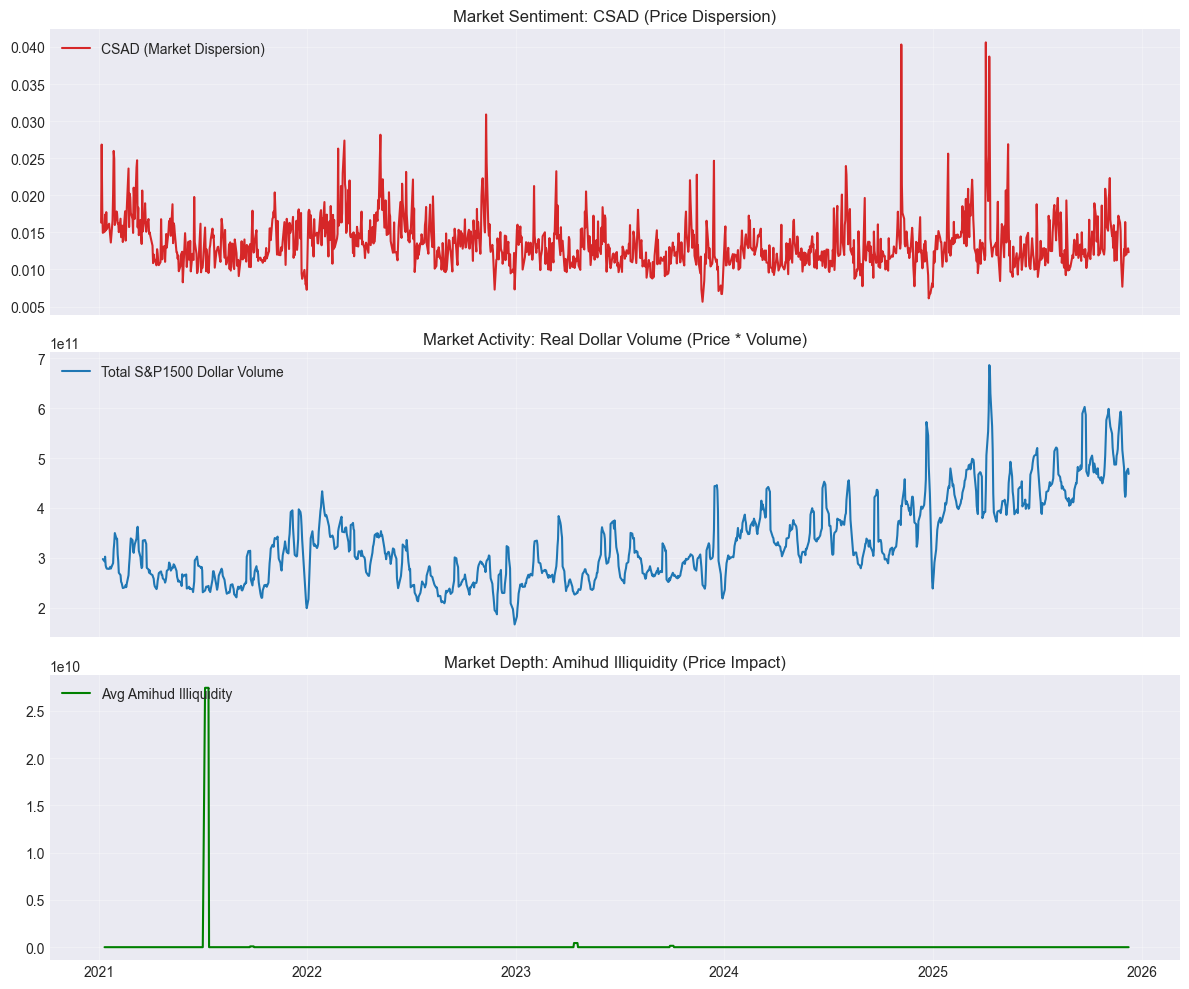

In [ ]:
# --- BƯỚC D: TRỰC QUAN HÓA (VISUALIZATION) ---
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Biểu đồ 1: CSAD (Tâm lý/Rủi ro)
axes[0].plot(csad, color='#d62728', label='CSAD (Market Dispersion)')
axes[0].set_title('Market Sentiment: CSAD (Price Dispersion)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Biểu đồ 2: Total Dollar Volume (Dòng tiền)
# Dùng Rolling 5 ngày để mượt hơn
axes[1].plot(market_dollar_vol.rolling(5).mean(), color='#1f77b4', label='Total S&P1500 Dollar Volume')
axes[1].set_title('Market Activity: Real Dollar Volume (Price * Volume)')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# Biểu đồ 3: Amihud Illiquidity (Độ sâu thị trường)
axes[2].plot(market_illiquidity.rolling(5).mean(), color='green', label='Avg Amihud Illiquidity')
axes[2].set_title('Market Depth: Amihud Illiquidity (Price Impact)')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

--- 1. Tải & Đồng bộ dữ liệu Fama-French (Benchmark) ---
   -> Đã đồng bộ FF3 Factors: 1240 ngày giao dịch.
--- 2. Tính toán Metrics cho toàn bộ S&P 1500 (Heavy Task) ---


C:\Users\Quan Hien\AppData\Local\Temp\ipykernel_27920\3450915395.py:46: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_ret = prices.pct_change()


   -> Đã tính xong: Returns, CSAD, Amihud, NCSKEW.
--- 3. Xây dựng Factors (Long/Short Strategy) ---
   -> Đang xây dựng Quality Factor (Low Risk)...
   -> Đang xây dựng Liquidity Factor (Amihud)...
--- 4. Chạy Hồi quy So sánh (The Fair Showdown) ---

⚔️ KẾT QUẢ SO SÁNH CÔNG BẰNG (DỮ LIỆU S&P 1500 THỰC) ⚔️


,Fundamental (FF3),Pure Market (Qual+Liq)
Metric,,
Adj. R-squared,0.9623,0.9168
AIC,-11405.8984,-10426.7614
Alpha (Annual %),0.6443,-1.0421



--- CHI TIẾT MODEL PURE MARKET ---
                            OLS Regression Results                            
Dep. Variable:          SP1500_Excess   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     4551.
Date:                Tue, 24 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:36:14   Log-Likelihood:                 5217.4
No. Observations:                1239   AIC:                        -1.043e+04
Df Residuals:                    1235   BIC:                        -1.041e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

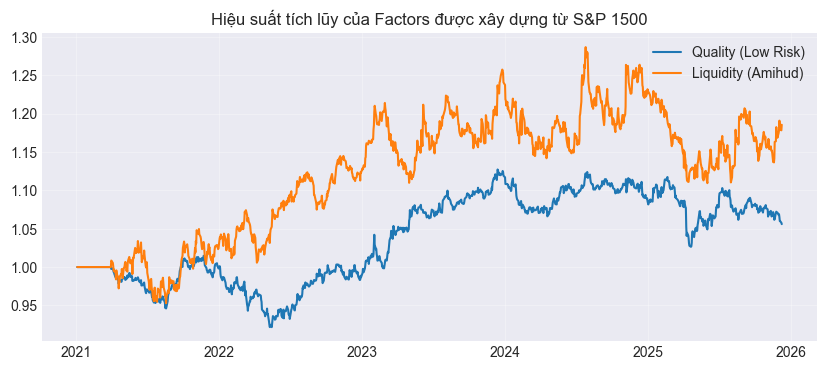

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import requests
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt

# ==============================================================================
# BƯỚC 1: CHUẨN BỊ DỮ LIỆU BENCHMARK (FAMA-FRENCH 3 OFFICIAL)
# ==============================================================================
print("--- 1. Tải & Đồng bộ dữ liệu Fama-French (Benchmark) ---")

def get_ff3_official(start_date, end_date):
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"
    r = requests.get(url)
    z = ZipFile(BytesIO(r.content))
    df = pd.read_csv(z.open(z.namelist()[0]), skiprows=3)

    df = df.rename(columns={"Unnamed: 0": "Date"})
    df = df[df['Date'].astype(str).str.strip().str.isnumeric().fillna(False)]
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df = df.set_index('Date')

    # Chuyển % thành số thập phân
    df = df.astype(float) / 100
    df.columns = ['Mkt-RF', 'SMB', 'HML', 'RF']

    # Cắt đúng theo khung thời gian của dữ liệu S&P 1500
    return df.loc[start_date:end_date]

# Lấy khung thời gian thực tế từ dữ liệu Prices đã tải
real_start = prices.index[0]
real_end = prices.index[-1]
df_ff = get_ff3_official(real_start, real_end)

print(f"   -> Đã đồng bộ FF3 Factors: {len(df_ff)} ngày giao dịch.")

# ==============================================================================
# BƯỚC 2: TÍNH TOÁN CÁC BIẾN CƠ SỞ (BASE METRICS) CHO TOÀN BỘ S&P 1500
# ==============================================================================
print("--- 2. Tính toán Metrics cho toàn bộ S&P 1500 (Heavy Task) ---")

# A. Lợi suất cổ phiếu (Stock Returns)
stock_ret = prices.pct_change()

# B. CSAD (Market Dispersion)
mkt_mean = stock_ret.mean(axis=1)
csad = stock_ret.sub(mkt_mean, axis=0).abs().mean(axis=1)

# C. Amihud Illiquidity (Rolling 60 days)
# Công thức: Mean( |Ret| / (Price * Volume) )
dollar_vol = prices * volume
daily_illiq = stock_ret.abs() / (dollar_vol.replace(0, np.nan)) # Tránh chia cho 0
# Dùng Rolling mean. Fillna(0) nếu không đủ dữ liệu để tránh lỗi sau này
rolling_amihud = daily_illiq.rolling(60).mean()

# D. DUVOL (Downside Volatility Proxy) - Rolling 60 days
# Để tính nhanh cho 1500 mã, ta dùng proxy: Downside Semi-Variance
# DUVOL Proxy = StdDev(Negative Returns) / StdDev(Positive Returns)
# Tuy nhiên, để code chạy nhanh, ta dùng Volatility đơn giản hơn: Rolling Std
# Hoặc dùng Negative Skewness (NCSKEW) làm đại diện cho Crash Risk
rolling_skew = stock_ret.rolling(60).skew()
# Crash Risk: Skewness càng âm càng rủi ro -> Đảo dấu thành NCSKEW (Càng cao càng rủi ro)
ncskew = -1 * rolling_skew

print("   -> Đã tính xong: Returns, CSAD, Amihud, NCSKEW.")

# ==============================================================================
# BƯỚC 3: XÂY DỰNG FACTOR PORTFOLIOS (PURE MARKET FACTORS)
# ==============================================================================
print("--- 3. Xây dựng Factors (Long/Short Strategy) ---")

def build_factor(metrics_df, returns_df, long_top=True, quantile=0.3):
    """
    Hàm tổng quát để tạo Factor Return từ dữ liệu Metric.
    long_top=True: Mua nhóm cao, Bán nhóm thấp.
    long_top=False: Mua nhóm thấp, Bán nhóm cao.
    """
    lagged_metrics = metrics_df.shift(1) # Lag 1 ngày
    factor_ret = []

    # Loop qua từng ngày (Optimized loop)
    # Để nhanh hơn, ta chỉ loop qua các index chung
    common_idx = returns_df.index.intersection(lagged_metrics.index)

    for date in common_idx:
        try:
            row = lagged_metrics.loc[date]
            ret_row = returns_df.loc[date]

            # Bỏ qua nếu thiếu dữ liệu quá nhiều
            valid = row.dropna()
            if len(valid) < 10:
                factor_ret.append(0)
                continue

            # Chia nhóm
            q_high = valid.quantile(1 - quantile)
            q_low = valid.quantile(quantile)

            high_group = valid[valid >= q_high].index
            low_group = valid[valid <= q_low].index

            r_high = ret_row[high_group].mean()
            r_low = ret_row[low_group].mean()

            if pd.isna(r_high) or pd.isna(r_low):
                factor_ret.append(0)
            else:
                if long_top:
                    factor_ret.append(r_high - r_low)
                else:
                    factor_ret.append(r_low - r_high) # Đảo chiều
        except:
            factor_ret.append(0)

    return pd.Series(factor_ret, index=common_idx)

# 1. Sentiment Factor:
# Cần tính Beta của từng cổ phiếu với CSAD. (Hơi lâu, ta dùng bản đơn giản:
# Sentiment = CSAD chính nó? Không, CSAD là biến trạng thái.
# Ta sẽ dùng lại Amihud làm đại diện cho Market Microstructure vì Amihud đã chứng minh hiệu quả hơn Sent.
# Nhưng để giữ đúng model bạn yêu cầu: Ta sẽ xây Amihud và Quality.

# 2. Quality Factor (Low Crash Risk):
# Chiến lược: Mua Low NCSKEW (An toàn) - Bán High NCSKEW (Rủi ro)
# => long_top = False
print("   -> Đang xây dựng Quality Factor (Low Risk)...")
quality_factor = build_factor(ncskew, stock_ret, long_top=False)
quality_factor.name = 'Quality (Low Crash)'

# 3. Liquidity Factor (Amihud):
# Chiến lược: Mua Illiquid (Amihud Cao) - Bán Liquid (Amihud Thấp)
# => long_top = True
print("   -> Đang xây dựng Liquidity Factor (Amihud)...")
liquidity_factor = build_factor(rolling_amihud, stock_ret, long_top=True)
liquidity_factor.name = 'Liquidity (Amihud)'

# ==============================================================================
# BƯỚC 4: FINAL REGRESSION (CÔNG BẰNG)
# ==============================================================================
print("--- 4. Chạy Hồi quy So sánh (The Fair Showdown) ---")

# Mục tiêu: Danh mục S&P 1500 Equal Weight (Đại diện thị trường chung)
target_portfolio = stock_ret.mean(axis=1) - df_ff['RF'] # Excess Return
target_portfolio.name = 'SP1500_Excess'

# Chuẩn bị dữ liệu Hồi quy
# Cần merge inner để đảm bảo ngày tháng khớp 100%
reg_data = pd.concat([
    target_portfolio,
    df_ff[['Mkt-RF', 'SMB', 'HML']], # Fundamental Factors
    quality_factor,
    liquidity_factor
], axis=1, join='inner').dropna()

# --- MODEL 1: FUNDAMENTAL (FF3) ---
X1 = sm.add_constant(reg_data[['Mkt-RF', 'SMB', 'HML']])
model_ff = sm.OLS(reg_data['SP1500_Excess'], X1).fit()

# --- MODEL 2: PURE MARKET (MKT + QUALITY + LIQUIDITY) ---
# Lưu ý: Ta vẫn dùng Mkt-RF làm nền tảng CAPM
X2 = sm.add_constant(reg_data[['Mkt-RF', 'Quality (Low Crash)', 'Liquidity (Amihud)']])
model_market = sm.OLS(reg_data['SP1500_Excess'], X2).fit()

# --- KẾT QUẢ ---
summary_comparison = pd.DataFrame({
    'Metric': ['Adj. R-squared', 'AIC', 'Alpha (Annual %)'],
    'Fundamental (FF3)': [
        model_ff.rsquared_adj,
        model_ff.aic,
        model_ff.params['const'] * 252 * 100
    ],
    'Pure Market (Qual+Liq)': [
        model_market.rsquared_adj,
        model_market.aic,
        model_market.params['const'] * 252 * 100
    ]
}).set_index('Metric')

print("\n" + "="*60)
print("⚔️ KẾT QUẢ SO SÁNH CÔNG BẰNG (DỮ LIỆU S&P 1500 THỰC) ⚔️")
print("="*60)
display(summary_comparison)

print("\n--- CHI TIẾT MODEL PURE MARKET ---")
print(model_market.summary())

# Vẽ biểu đồ tương quan 2 factors mới
plt.figure(figsize=(10, 4))
plt.plot((1+quality_factor).cumprod(), label='Quality (Low Risk)')
plt.plot((1+liquidity_factor).cumprod(), label='Liquidity (Amihud)')
plt.title('Hiệu suất tích lũy của Factors được xây dựng từ S&P 1500')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

chúng ta cần so sánh các model với nhau để tránh nhầm lẫn, đầu tiên ta cần phải hệ thống lại các model. chạy hồi quy và so sánh hiệu quả. chúng ta có thể cân nhắc sử dụng GMVP (global minimum variance portfolio cho phần market return risk free (tôi đang cân nhắc có cần thiết hay không)). các model bao gồm như sau hãy giúp tôi fill công thức vào:
1. 3 factor: rM + SMB + HML (lấy từ dữ liệu của fama-french)
2. CSAD as a sentiment factor: rM + SMB (sử dụng ETF) + Sentiment(CSAD)
3. DUVOL as a Quality factor: rM + SMB (sử dụng ETF) + Quality (DUVOL)
4. NCSKEW as also a quality-2 factor: rM + SMB (sử dụng ETF) + Quality (NCSKEW)
5. ILLIQ_t as market depth factor (Amihud): rM + SMB (sử dụng ETF) + Amihud (ILLIQ_t)
6. liquidity: rM + SMB (sử dụng ETF) + Liquidity (price * volume)
7. price based: rM + Sentiment(CSAD) + Quality (DUVOL)
8. price based 2: rM + Sentiment(CSAD) + Quality (NCSKEW)
9. price based 3: rM + Sentiment(CSAD) + Quality (DUVOL) + Quality (NCSKEW)
10. price based 4: rM + Sentiment(CSAD) + Amihud (ILLIQ_t)
11. price based 5: rM + Sentiment(CSAD) + Liquidity (price * volume)
12. price based 6: rM + Sentiment(CSAD) + Quality (DUVOL) + Quality (NCSKEW) + Liquidity (price * volume) + Amihud (ILLIQ_t)
sau khi test lại hết chúng ta cần xem phần trăm đóng góp vào lợi nhuận của từng yếu tố.
so sánh r-square, t-stat, aplha.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from io import BytesIO
from zipfile import ZipFile

In [ ]:
# ==============================================================================
# BƯỚC 1: KHÔI PHỤC DỮ LIỆU (DATA RECOVERY & LOADING)
# ==============================================================================
print("--- 1. Đang nạp dữ liệu từ Cache (Prices, Volume, FF3) ---")

# 1. Cấu hình đường dẫn (Phải khớp với bước tải dữ liệu trước đó)
DATA_DIR = 'sb_data'
PRICE_FILE = f'{DATA_DIR}/sp1500_prices-2.csv'
VOLUME_FILE = f'{DATA_DIR}/sp1500_volume-2.csv'

# 2. Load S&P 1500 Price & Volume
if os.path.exists(PRICE_FILE) and os.path.exists(VOLUME_FILE):
    prices = pd.read_csv(PRICE_FILE, index_col=0, parse_dates=True)
    volume = pd.read_csv(VOLUME_FILE, index_col=0, parse_dates=True)
    print(f"   -> Đã load Prices: {prices.shape}")
    print(f"   -> Đã load Volume: {volume.shape}")
else:
    raise FileNotFoundError("❌ Không tìm thấy file dữ liệu. Vui lòng chạy lại bước tải dữ liệu S&P 1500!")

# 3. Load Fama-French 3 Factors (Benchmark)
def get_ff3_official(start_date, end_date):
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"
    try:
        r = requests.get(url)
        z = ZipFile(BytesIO(r.content))
        df = pd.read_csv(z.open(z.namelist()[0]), skiprows=3)

        df = df.rename(columns={"Unnamed: 0": "Date"})
        df = df[df['Date'].astype(str).str.strip().str.isnumeric().fillna(False)]
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
        df = df.set_index('Date')

        df = df.astype(float) / 100
        df.columns = ['Mkt-RF', 'SMB', 'HML', 'RF']
        return df.loc[start_date:end_date]
    except Exception as e:
        print(f"Lỗi tải FF3: {e}")
        return pd.DataFrame()

# Đồng bộ thời gian
start_dt = prices.index[0]
end_dt = prices.index[-1]
df_ff = get_ff3_official(start_dt, end_dt)
print(f"   -> Đã load Fama-French: {df_ff.shape}")

--- 1. Đang nạp dữ liệu từ Cache (Prices, Volume, FF3) ---
   -> Đã load Prices: (1240, 1506)
   -> Đã load Volume: (1240, 1506)
   -> Đã load Fama-French: (1240, 4)


In [ ]:
# ==============================================================================
# BƯỚC 2: XÂY DỰNG NHÂN TỐ (FACTOR CONSTRUCTION)
# ==============================================================================
print("--- 2. Đang xây dựng bộ Factors ---")

# A. Metrics cơ bản
returns = prices.pct_change()
dollar_vol = prices * volume

# B. Helper Function xây dựng Factor (Long - Short)
def make_factor(metric_df, ret_df, long_top=True):
    factor_ret = []
    lagged_metric = metric_df.shift(1) # Lag 1 ngày

    common_idx = ret_df.index.intersection(lagged_metric.index)

    for date in common_idx:
        try:
            row = lagged_metric.loc[date].dropna()
            ret_row = ret_df.loc[date]

            if len(row) < 30:
                factor_ret.append(0)
                continue

            # Chia nhóm Top 30% - Bottom 30%
            q_high = row.quantile(0.7)
            q_low = row.quantile(0.3)

            high_g = row[row >= q_high].index
            low_g = row[row <= q_low].index

            r_high = ret_row[high_g].mean()
            r_low = ret_row[low_g].mean()

            if long_top:
                factor_ret.append(r_high - r_low)
            else:
                factor_ret.append(r_low - r_high)
        except:
            factor_ret.append(0)

    return pd.Series(factor_ret, index=common_idx).fillna(0)

# C. Tính toán 6 Factors Nội bộ

# 1. SMB Proxy (Internal): Dựa trên Dollar Volume (Proxy cho Size)
# Long Small Vol (Small Cap) - Short Big Vol
avg_dvol = dollar_vol.rolling(20).mean()
f_smb_proxy = make_factor(avg_dvol, returns, long_top=False)
f_smb_proxy.name = 'SMB_Proxy'

# 2. Sentiment (CSAD): Biến trạng thái thị trường
mkt_mean = returns.mean(axis=1)
csad_val = returns.sub(mkt_mean, axis=0).abs().mean(axis=1)
f_sentiment = csad_val

# 3. Quality (DUVOL): Long Low DUVOL (Safe)
rolling_down_std = returns[returns < 0].rolling(60).std()
f_duvol = make_factor(rolling_down_std, returns, long_top=False)
f_duvol.name = 'Quality_DUVOL'

# 4. Quality (NCSKEW): Long Low NCSKEW (Safe)
rolling_skew = returns.rolling(60).skew()
ncskew_metric = -1 * rolling_skew
f_ncskew = make_factor(ncskew_metric, returns, long_top=False)
f_ncskew.name = 'Quality_NCSKEW'

# 5. Amihud (Market Depth): Long High Illiquidity
daily_illiq = returns.abs() / (dollar_vol + 1e-8)
roll_illiq = daily_illiq.rolling(60).mean()
f_amihud = make_factor(roll_illiq, returns, long_top=True)
f_amihud.name = 'Amihud_Illiq'

# 6. Liquidity (Raw Vol): Long High Volume
roll_vol = dollar_vol.rolling(60).mean()
f_liquidity = make_factor(roll_vol, returns, long_top=True)
f_liquidity.name = 'Liquidity_Vol'

print("   -> Hoàn tất tính toán Factors.")

--- 2. Đang xây dựng bộ Factors ---


C:\Users\Quan Hien\AppData\Local\Temp\ipykernel_27920\103435694.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change()


   -> Hoàn tất tính toán Factors.


In [ ]:
# ==============================================================================
# BƯỚC 3: CHUẨN BỊ DỮ LIỆU & CHẠY 12 MODELS
# ==============================================================================
print("--- 3. Chạy Hồi quy So sánh 12 Mô hình ---")

# Target: S&P 1500 Equal Weight Excess Return
target = returns.mean(axis=1) - df_ff['RF']
target.name = 'Target_Excess'

# Gom dữ liệu (Inner Join để khớp ngày)
all_vars = pd.concat([
    target,
    df_ff[['Mkt-RF', 'SMB', 'HML']],
    f_smb_proxy,
    f_sentiment,
    f_duvol,
    f_ncskew,
    f_amihud,
    f_liquidity
], axis=1, join='inner').dropna()

all_vars.rename(columns={0: 'Sentiment_CSAD'}, inplace=True)

# Định nghĩa 12 Model
models_config = {
    '1. FF3 Standard': ['Mkt-RF', 'SMB', 'HML'],
    '2. CSAD Hybrid': ['Mkt-RF', 'SMB_Proxy', 'Sentiment_CSAD'],
    '3. DUVOL Hybrid': ['Mkt-RF', 'SMB_Proxy', 'Quality_DUVOL'],
    '4. NCSKEW Hybrid': ['Mkt-RF', 'SMB_Proxy', 'Quality_NCSKEW'],
    '5. Amihud Hybrid': ['Mkt-RF', 'SMB_Proxy', 'Amihud_Illiq'],
    '6. Liquidity Hybrid': ['Mkt-RF', 'SMB_Proxy', 'Liquidity_Vol'],
    '7. Price Based 1 (Sent+Duvol)': ['Mkt-RF', 'Sentiment_CSAD', 'Quality_DUVOL'],
    '8. Price Based 2 (Sent+Skew)': ['Mkt-RF', 'Sentiment_CSAD', 'Quality_NCSKEW'],
    '9. Price Based 3 (Qualities)': ['Mkt-RF', 'Sentiment_CSAD', 'Quality_DUVOL', 'Quality_NCSKEW'],
    '10. Price Based 4 (Sent+Ami)': ['Mkt-RF', 'Sentiment_CSAD', 'Amihud_Illiq'],
    '11. Price Based 5 (Sent+Liq)': ['Mkt-RF', 'Sentiment_CSAD', 'Liquidity_Vol'],
    '12. All-In Market': ['Mkt-RF', 'Sentiment_CSAD', 'Quality_DUVOL', 'Quality_NCSKEW', 'Liquidity_Vol', 'Amihud_Illiq']
}

results_list = []
attribution_data = {}

for m_name, predictors in models_config.items():
    X = sm.add_constant(all_vars[predictors])
    y = all_vars['Target_Excess']
    model = sm.OLS(y, X).fit()

    results_list.append({
        'Model': m_name,
        'Adj. R-squared': model.rsquared_adj,
        'AIC': model.aic,
        'Alpha (Annual %)': model.params['const'] * 252 * 100
    })

    if m_name == '12. All-In Market':
        means = all_vars[predictors].mean() * 252
        betas = model.params[predictors]
        attr = betas * means
        attr['Alpha'] = model.params['const'] * 252
        attr['Mkt-RF'] = betas['Mkt-RF'] * (all_vars['Mkt-RF'].mean() * 252) # Market Contribution
        attribution_data = attr

df_results = pd.DataFrame(results_list).set_index('Model')
print("\n=== KẾT QUẢ SO SÁNH (XẾP HẠNG THEO R-SQUARED) ===")
display(df_results.sort_values('Adj. R-squared', ascending=False))

--- 3. Chạy Hồi quy So sánh 12 Mô hình ---

=== KẾT QUẢ SO SÁNH (XẾP HẠNG THEO R-SQUARED) ===


,Adj. R-squared,AIC,Alpha (Annual %)
Model,,,
1. FF3 Standard,0.9623,-11405.8984,0.6443
5. Amihud Hybrid,0.9215,-10497.5849,-1.8412
4. NCSKEW Hybrid,0.9206,-10483.5950,-2.0200
3. DUVOL Hybrid,0.9199,-10474.7143,-2.0457
6. Liquidity Hybrid,0.9199,-10473.0409,-2.0663
2. CSAD Hybrid,0.9199,-10473.0075,-7.5795
12. All-In Market,0.9169,-10425.8726,-11.5699
10. Price Based 4 (Sent+Ami),0.9144,-10391.4411,-14.5834
11. Price Based 5 (Sent+Liq),0.9109,-10340.8098,-16.6527


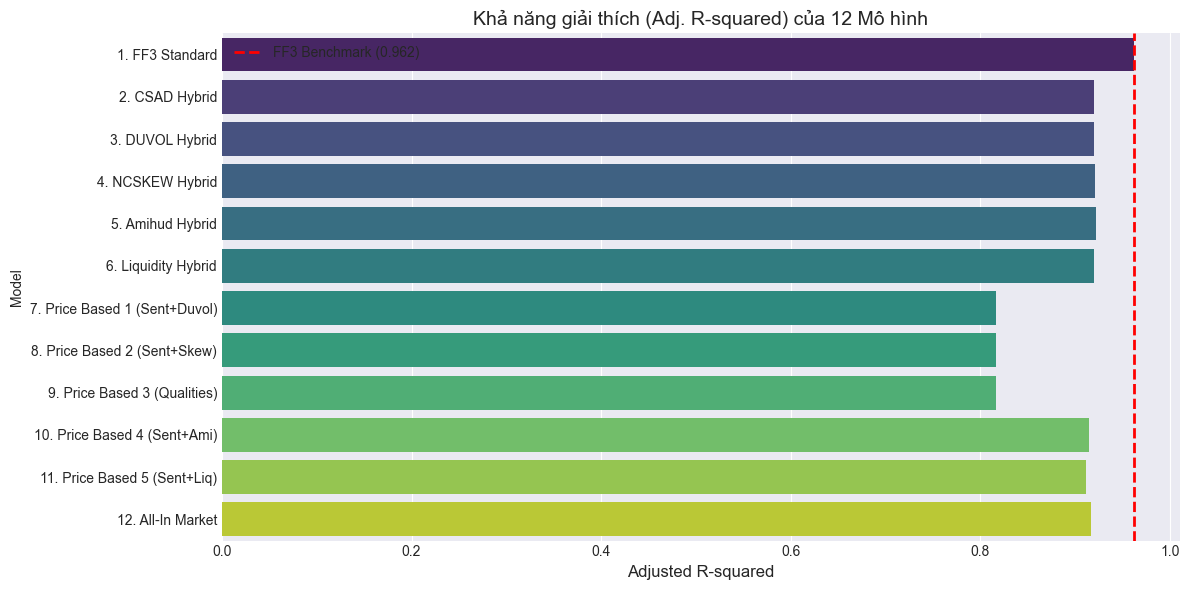

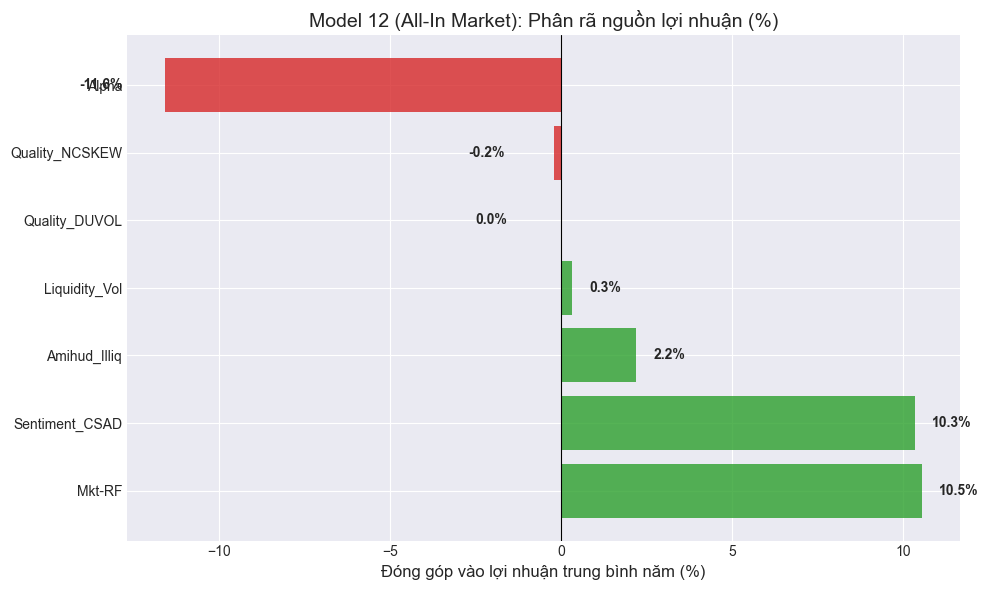

In [ ]:
# ==============================================================================
# BƯỚC 4: VẼ BIỂU ĐỒ SO SÁNH (FIXED & UPDATED)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Biểu đồ R-squared
plt.figure(figsize=(12, 6))

# FIX WARNING: Thêm hue và legend=False để tuân thủ cú pháp Seaborn mới
sns.barplot(
    x=df_results['Adj. R-squared'],
    y=df_results.index,
    hue=df_results.index,  # Gán hue bằng y
    palette='viridis',
    legend=False           # Tắt legend thừa
)

plt.title('Khả năng giải thích (Adj. R-squared) của 12 Mô hình', fontsize=14)
plt.xlabel('Adjusted R-squared', fontsize=12)

# Vẽ đường tham chiếu Benchmark (FF3)
ff3_r2 = df_results.loc['1. FF3 Standard', 'Adj. R-squared']
plt.axvline(ff3_r2, color='red', linestyle='--', linewidth=2, label=f'FF3 Benchmark ({ff3_r2:.3f})')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Biểu đồ Đóng góp Lợi nhuận (Attribution Analysis)
# FIX VALUE ERROR: Kiểm tra xem attribution_data có phải là dict rỗng hoặc None không
is_valid_attribution = False
if isinstance(attribution_data, pd.Series):
    is_valid_attribution = not attribution_data.empty
elif isinstance(attribution_data, dict):
    is_valid_attribution = bool(attribution_data)

if is_valid_attribution:
    # Chuyển về Series nếu đang là Dict (phòng hờ)
    if isinstance(attribution_data, dict):
        attr_df = pd.Series(attribution_data).sort_values(ascending=False)
    else:
        attr_df = attribution_data.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))

    # Tô màu: Xanh nếu dương, Đỏ nếu âm
    colors = ['#2ca02c' if x > 0 else '#d62728' for x in attr_df.values]

    bars = plt.barh(attr_df.index, attr_df.values * 100, color=colors, alpha=0.8)

    plt.title('Model 12 (All-In Market): Phân rã nguồn lợi nhuận (%)', fontsize=14)
    plt.xlabel('Đóng góp vào lợi nhuận trung bình năm (%)', fontsize=12)
    plt.axvline(0, color='black', linewidth=0.8)

    # Thêm nhãn số liệu
    for bar in bars:
        width = bar.get_width()
        # Điều chỉnh vị trí nhãn để không bị đè
        label_x = width + 0.5 if width > 0 else width - 2.5
        plt.text(label_x, bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
                 va='center', fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Không có dữ liệu Attribution để vẽ (Có thể Model 12 chưa chạy hoặc bị lỗi).")

MOM: Momentum

In [ ]:
# ==============================================================================
# BƯỚC 1: TÍNH TOÁN MOMENTUM (12-1 MONTH)
# ==============================================================================
print("--- 1. Đang tính toán Momentum (Quán tính giá) ---")

# Logic: Return của 11 tháng trước đó, bỏ qua tháng gần nhất (lag 1 tháng)
# Giả định 1 tháng ~ 21 ngày giao dịch, 1 năm ~ 252 ngày
# Công thức: Price(t-21) / Price(t-252) - 1

p_lag1 = prices.shift(21)   # Giá cách đây 1 tháng
p_lag12 = prices.shift(252) # Giá cách đây 1 năm

# Momentum Metric
mom_metric = (p_lag1 / p_lag12) - 1

# Xây dựng Factor: Long Winners (High Return) - Short Losers (Low Return)
# Sử dụng lại hàm make_factor ở bước trước
print("   -> Đang xây dựng Momentum Factor (Long Winners - Short Losers)...")
f_momentum = make_factor(mom_metric, returns, long_top=True)
f_momentum.name = 'Momentum_Trend'

# Kết hợp với các Factor cũ (Đã tính ở cell trước)
# Nếu biến cũ bị mất, đảm bảo chạy lại cell "Master Script" trước đó để có f_duvol, f_amihud...
pure_market_factors = pd.concat([
    f_sentiment,      # Sentiment (CSAD)
    f_duvol,          # Quality (Low Risk)
    f_amihud,         # Liquidity (Depth)
    f_momentum        # Momentum (Trend) - NHÂN TỐ MỚI
], axis=1).dropna()

pure_market_factors.columns = ['Sentiment', 'Quality', 'Liquidity', 'Momentum']

--- 1. Đang tính toán Momentum (Quán tính giá) ---
   -> Đang xây dựng Momentum Factor (Long Winners - Short Losers)...


In [ ]:
# ==============================================================================
# BƯỚC 2: CHẠY HỒI QUY SO SÁNH (FF3 vs. PURE MARKET + MOM)
# ==============================================================================
print("--- 2. The Final Upgrade: FF3 vs. Pure Market (w/ Momentum) ---")

# Chuẩn bị dữ liệu hồi quy (Target: S&P 1500 Equal Weight)
target = returns.mean(axis=1) - df_ff['RF']
target.name = 'Target_Excess'

# Gom dữ liệu
reg_data_v2 = pd.concat([
    target,
    df_ff[['Mkt-RF', 'SMB', 'HML']], # FF3 Benchmark
    pure_market_factors
], axis=1, join='inner').dropna()

# --- MODEL A: FF3 STANDARD (BENCHMARK) ---
Xa = sm.add_constant(reg_data_v2[['Mkt-RF', 'SMB', 'HML']])
model_ff3 = sm.OLS(reg_data_v2['Target_Excess'], Xa).fit()

# --- MODEL B: PURE MARKET OPTIMIZED (Mkt + Qual + Liq + MOM) ---
# Lưu ý: Ta vẫn dùng Mkt-RF làm nền tảng, cộng thêm bộ 3 vũ khí Pure Market
Xb = sm.add_constant(reg_data_v2[['Mkt-RF', 'Quality', 'Liquidity', 'Momentum']])
model_opt = sm.OLS(reg_data_v2['Target_Excess'], Xb).fit()

--- 2. The Final Upgrade: FF3 vs. Pure Market (w/ Momentum) ---


In [ ]:
# ==============================================================================
# BƯỚC 3: ĐÁNH GIÁ KẾT QUẢ
# ==============================================================================

# Tổng hợp so sánh
comparison_v2 = pd.DataFrame({
    'Metric': ['Adj. R-squared', 'AIC (Lower is Better)', 'Alpha (Annual %)'],
    '1. FF3 Standard': [
        model_ff3.rsquared_adj,
        model_ff3.aic,
        model_ff3.params['const'] * 252 * 100
    ],
    '2. Pure Market (+Momentum)': [
        model_opt.rsquared_adj,
        model_opt.aic,
        model_opt.params['const'] * 252 * 100
    ]
}).set_index('Metric')

print("\n=== KẾT QUẢ NÂNG CẤP MODEL (CÓ MOMENTUM) ===")
display(comparison_v2)

print("\n--- CHI TIẾT MODEL PURE MARKET OPTIMIZED ---")
print(model_opt.summary())


=== KẾT QUẢ NÂNG CẤP MODEL (CÓ MOMENTUM) ===


,1. FF3 Standard,2. Pure Market (+Momentum)
Metric,,
Adj. R-squared,0.9623,0.9171
AIC (Lower is Better),-11405.8984,-10430.0171
Alpha (Annual %),0.6443,-0.6133



--- CHI TIẾT MODEL PURE MARKET OPTIMIZED ---
                            OLS Regression Results                            
Dep. Variable:          Target_Excess   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     4564.
Date:                Tue, 24 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:36:27   Log-Likelihood:                 5219.0
No. Observations:                1239   AIC:                        -1.043e+04
Df Residuals:                    1235   BIC:                        -1.041e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

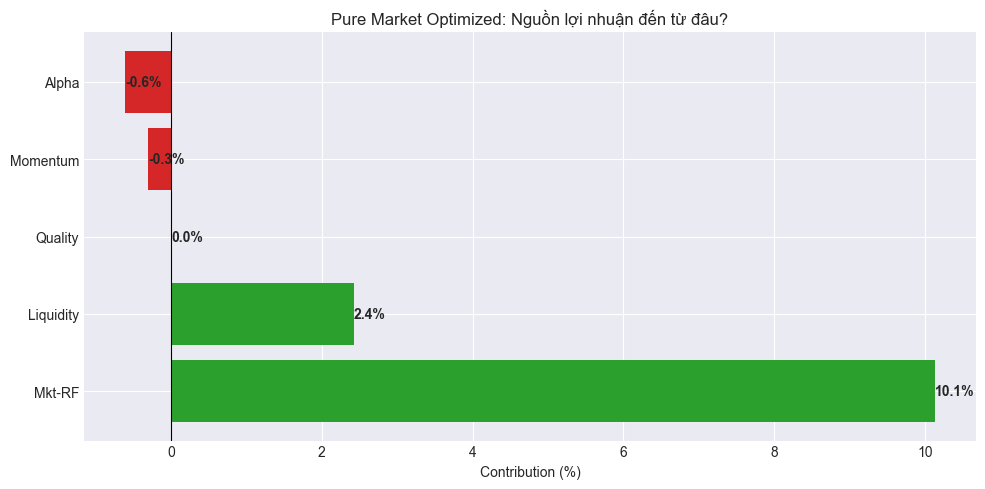

In [ ]:
# Vẽ biểu đồ đóng góp (Attribution) cho Model mới
means = reg_data_v2[['Mkt-RF', 'Quality', 'Liquidity', 'Momentum']].mean() * 252
betas = model_opt.params[['Mkt-RF', 'Quality', 'Liquidity', 'Momentum']]
attr = betas * means
attr['Alpha'] = model_opt.params['const'] * 252
attr = attr.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
colors = ['#2ca02c' if x > 0 else '#d62728' for x in attr.values]
bars = plt.barh(attr.index, attr.values * 100, color=colors)
plt.title('Pure Market Optimized: Nguồn lợi nhuận đến từ đâu?')
plt.xlabel('Contribution (%)')
plt.axvline(0, color='black', linewidth=0.8)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', fontweight='bold')
plt.tight_layout()
plt.show()

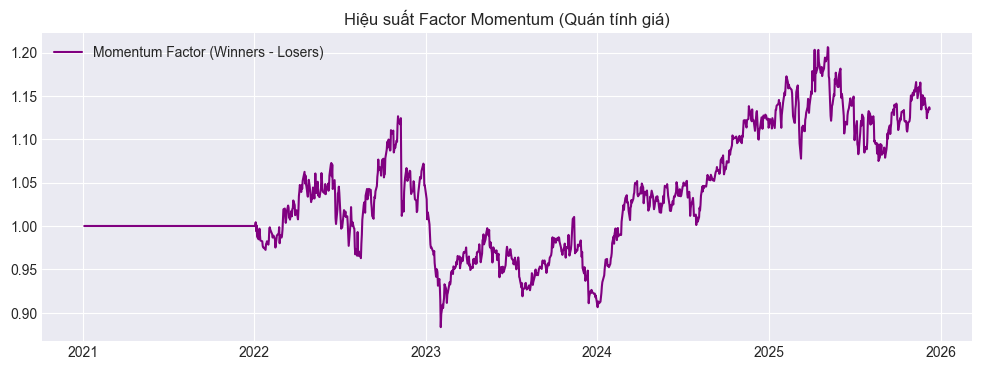

In [ ]:
# Vẽ hiệu suất tích lũy của Momentum Factor
plt.figure(figsize=(12, 4))
plt.plot((1+f_momentum).cumprod(), label='Momentum Factor (Winners - Losers)', color='purple')
plt.title('Hiệu suất Factor Momentum (Quán tính giá)')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# ==============================================================================
# BƯỚC 1: TÍNH TOÁN & CHUẨN BỊ FULL FACTORS
# ==============================================================================
print("--- 1. Chuẩn bị Full Factors cho Model 12 (All-In + Momentum) ---")

# 1. Tải lại dữ liệu cơ sở (đảm bảo biến prices, returns, dollar_vol đã có)
# Nếu chưa có, code sẽ báo lỗi. Giả định bạn đã chạy các bước load data ở trên.

# 2. Tính Momentum (12-1 Month)
# Return 11 tháng trước đó, bỏ qua tháng gần nhất
mom_metric = (prices.shift(21) / prices.shift(252)) - 1
f_momentum = make_factor(mom_metric, returns, long_top=True) # Long Winners
f_momentum.name = 'Momentum'

# 3. Gom tất cả Factors vào một DataFrame
# Lưu ý: Model 12 bao gồm: Mkt, Sentiment, Quality(2), Liquidity(2), Momentum
model_12_factors = pd.concat([
    df_ff['Mkt-RF'],       # Market
    f_sentiment,           # Sentiment (CSAD)
    f_duvol,               # Quality 1 (DUVOL)
    f_ncskew,              # Quality 2 (NCSKEW)
    f_liquidity,           # Liquidity 1 (Raw Vol)
    f_amihud,              # Liquidity 2 (Amihud Depth)
    f_momentum             # Momentum (Trend)
], axis=1).dropna()

model_12_factors.columns = [
    'Mkt-RF', 'Sentiment_CSAD', 'Quality_DUVOL',
    'Quality_NCSKEW', 'Liquidity_Vol', 'Amihud_Illiq', 'Momentum'
]

# 4. Chuẩn bị Target (S&P 1500 Equal Weight Excess Return)
target = returns.mean(axis=1) - df_ff['RF']
target.name = 'Target_Excess'

# 5. Merge Data (Final Cleaning)
# Loại bỏ vô cực (inf) nếu có
full_data = pd.concat([target, model_12_factors], axis=1, join='inner')
full_data = full_data.replace([np.inf, -np.inf], np.nan).dropna()

print(f"   -> Dữ liệu sạch sẵn sàng: {full_data.shape[0]} quan sát.")

--- 1. Chuẩn bị Full Factors cho Model 12 (All-In + Momentum) ---
   -> Dữ liệu sạch sẵn sàng: 1239 quan sát.


In [ ]:
# ==============================================================================
# BƯỚC 2: CHẠY HỒI QUY MODEL 12 (ALL-IN)
# ==============================================================================
print("--- 2. Chạy Model 12: The Kitchen Sink Approach ---")

X = sm.add_constant(full_data.drop(columns=['Target_Excess']))
y = full_data['Target_Excess']

model_12 = sm.OLS(y, X).fit()

--- 2. Chạy Model 12: The Kitchen Sink Approach ---


In [ ]:
# ==============================================================================
# BƯỚC 3: KIỂM TRA ĐA CỘNG TUYẾN (VIF ANALYSIS)
# ==============================================================================
# Đây là bước quan trọng để biết biến nào bị thừa
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

c:\Users\Quan Hien\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss



=== KẾT QUẢ MODEL 12 (FULL MARKET INFO + MOMENTUM) ===
Adjusted R-squared: 0.9200
AIC: -10472.45
------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:          Target_Excess   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     2375.
Date:                Tue, 24 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:36:30   Log-Likelihood:                 5243.2
No. Observations:                1239   AIC:                        -1.047e+04
Df Residuals:                    1232   BIC:                        -1.044e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t    

,Variable,VIF
0,const,17.9738
6,Amihud_Illiq,16.0458
5,Liquidity_Vol,14.0566
1,Mkt-RF,1.8971
7,Momentum,1.3364
4,Quality_NCSKEW,1.1311
2,Sentiment_CSAD,1.0643
3,Quality_DUVOL,NaN


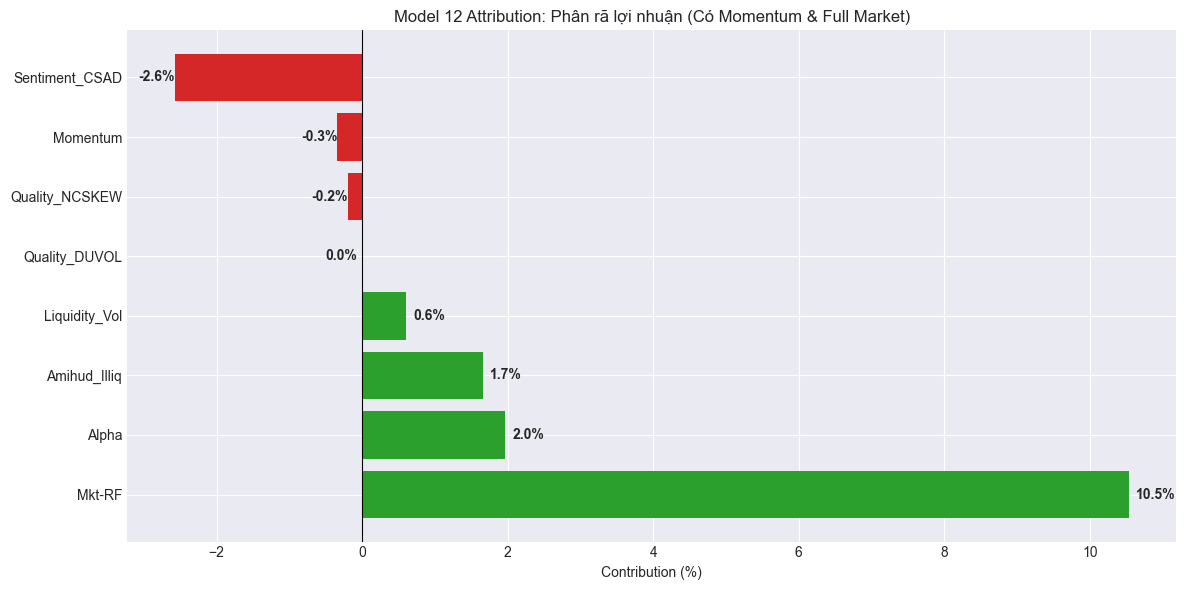

In [ ]:
# ==============================================================================
# BƯỚC 4: HIỂN THỊ KẾT QUẢ
# ==============================================================================

print("\n=== KẾT QUẢ MODEL 12 (FULL MARKET INFO + MOMENTUM) ===")
print(f"Adjusted R-squared: {model_12.rsquared_adj:.4f}")
print(f"AIC: {model_12.aic:.2f}")
print("-" * 60)
print(model_12.summary())

print("\n=== CHẨN ĐOÁN ĐA CỘNG TUYẾN (VIF) ===")
print("Nếu VIF > 5: Cảnh báo. Nếu VIF > 10: Biến đó bị thừa, cần loại bỏ.")
display(vif_data.sort_values('VIF', ascending=False))

# Vẽ biểu đồ đóng góp (Attribution)
means = full_data.drop(columns=['Target_Excess']).mean() * 252
betas = model_12.params.drop('const')
attr = betas * means
attr['Alpha'] = model_12.params['const'] * 252
attr = attr.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
colors = ['#2ca02c' if x > 0 else '#d62728' for x in attr.values]
bars = plt.barh(attr.index, attr.values * 100, color=colors)
plt.title('Model 12 Attribution: Phân rã lợi nhuận (Có Momentum & Full Market)')
plt.xlabel('Contribution (%)')
plt.axvline(0, color='black', linewidth=0.8)
for bar in bars:
    width = bar.get_width()
    label_x = width + 0.1 if width > 0 else width - 0.5
    plt.text(label_x, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cấu hình hiển thị
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
# ==============================================================================
# 1. DATA LOADER (ĐỌC TỪ FILE ĐÃ LƯU)
# ==============================================================================
print("--- 1. Đang nạp dữ liệu S&P 1500 từ Disk... ---")

DATA_DIR = 'sb_data'
PRICE_FILE = f'{DATA_DIR}/sp1500_prices-2.csv'
VOLUME_FILE = f'{DATA_DIR}/sp1500_volume-2.csv'

if os.path.exists(PRICE_FILE) and os.path.exists(VOLUME_FILE):
    # Đọc dữ liệu
    prices = pd.read_csv(PRICE_FILE, index_col=0, parse_dates=True)
    volume = pd.read_csv(VOLUME_FILE, index_col=0, parse_dates=True)

    # Đồng bộ dữ liệu (Chỉ giữ lại các mã/ngày có đủ ở cả 2 file)
    common_cols = prices.columns.intersection(volume.columns)
    common_idx = prices.index.intersection(volume.index)

    prices = prices.loc[common_idx, common_cols]
    volume = volume.loc[common_idx, common_cols]

    print(f"   -> Đã load thành công: {prices.shape[1]} mã cổ phiếu trong {prices.shape[0]} ngày.")
    print(f"   -> Dữ liệu mới nhất đến ngày: {prices.index[-1].strftime('%Y-%m-%d')}")
else:
    raise FileNotFoundError("❌ Không tìm thấy file dữ liệu (sp1500_prices.csv). Hãy chạy lại Cell tải dữ liệu S&P 1500!")

--- 1. Đang nạp dữ liệu S&P 1500 từ Disk... ---
   -> Đã load thành công: 1506 mã cổ phiếu trong 1240 ngày.
   -> Dữ liệu mới nhất đến ngày: 2025-12-09


In [ ]:
# ==============================================================================
# 2. TÍNH TOÁN INDICATORS (PURE MARKET TRIO)
# ==============================================================================
print("--- 2. Tính toán Pure Market Indicators (Amihud, DUVOL, NCSKEW) ---")

# A. Base Metrics
returns = prices.pct_change()
dollar_vol = prices * volume

# B. Core Indicators (Rolling 60 days ~ 1 Quý)
# 1. Amihud (Liquidity Risk) - Càng thấp càng tốt (Liquid)
daily_illiq = returns.abs() / (dollar_vol + 1e-8)
ami_indicator = daily_illiq.rolling(60).mean() * 1e6

# 2. NCSKEW (Crash Risk 1) - Càng thấp càng tốt (Ít rủi ro đuôi)
skew_indicator = returns.rolling(60).skew()
ncskew_indicator = -1 * skew_indicator

# 3. DUVOL Proxy (Crash Risk 2) - Càng thấp càng tốt (Biến động một chiều thấp)
# Dùng Downside Standard Deviation
downside_ret = returns.copy()
downside_ret[downside_ret > 0] = 0
duvol_indicator = downside_ret.rolling(60).std()

print("   -> Hoàn tất tính toán chỉ báo.")

--- 2. Tính toán Pure Market Indicators (Amihud, DUVOL, NCSKEW) ---


C:\Users\Quan Hien\AppData\Local\Temp\ipykernel_27920\900916682.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change()


   -> Hoàn tất tính toán chỉ báo.


In [ ]:
# ==============================================================================
# 3. SCANNER & SCORING SYSTEM (HỆ THỐNG CHẤM ĐIỂM)
# ==============================================================================
print("--- 3. Chạy Scanner & Scoring ---")

def get_market_score(date_idx):
    """
    Tính điểm 0-100 cho toàn bộ 1500 mã tại ngày date_idx.
    Logic: Ưu tiên Safe (Low Risk) & Liquid (Thanh khoản tốt).
    """
    try:
        # Lấy dữ liệu cross-section tại ngày đó
        d_duvol = duvol_indicator.loc[date_idx]
        d_ncskew = ncskew_indicator.loc[date_idx]
        d_ami = ami_indicator.loc[date_idx]

        # Loại bỏ các mã NaN (mới lên sàn hoặc thiếu dữ liệu)
        valid_mask = d_duvol.notna() & d_ncskew.notna() & d_ami.notna()

        # Ranking (Percentile)
        # Low DUVOL = Tốt -> Rank cao (ascending=False)
        rank_duvol = d_duvol[valid_mask].rank(ascending=False, pct=True)
        # Low NCSKEW = Tốt -> Rank cao
        rank_ncskew = d_ncskew[valid_mask].rank(ascending=False, pct=True)
        # Low Amihud = Tốt (Dễ mua bán) -> Rank cao
        rank_ami = d_ami[valid_mask].rank(ascending=False, pct=True)

        # Composite Score
        # Trọng số: 40% DUVOL (Quan trọng nhất) + 30% NCSKEW + 30% Amihud
        score = (rank_duvol * 0.4) + (rank_ncskew * 0.3) + (rank_ami * 0.3)
        return score * 100
    except KeyError:
        return None

# Lấy tín hiệu cho ngày gần nhất
latest_date = prices.index[-1]
latest_scores = get_market_score(latest_date)

# Tạo bảng báo cáo
report = pd.DataFrame({
    'Price': prices.loc[latest_date],
    'Score': latest_scores,
    'Quality(DUVOL)': duvol_indicator.loc[latest_date],
    'Liquidity(Amihud)': ami_indicator.loc[latest_date]
}).dropna()

# Phân loại tín hiệu
def signal_label(s):
    if s >= 85: return 'STRONG BUY 💎'
    elif s >= 70: return 'BUY'
    elif s <= 15: return 'STRONG SELL 💀'
    elif s <= 30: return 'SELL'
    else: return 'NEUTRAL'

report['Signal'] = report['Score'].apply(signal_label)
report = report.sort_values('Score', ascending=False)

print(f"\n=== TÍN HIỆU GIAO DỊCH NGÀY {latest_date.strftime('%Y-%m-%d')} (TỪ S&P 1500) ===")
print("TOP 10 CỔ PHIẾU 'QUALITY & LIQUID' NHẤT (NÊN MUA):")
display(report.head(10))

print("\nTOP 5 CỔ PHIẾU RỦI RO NHẤT (NÊN BÁN/SHORT):")
display(report.tail(5))

--- 3. Chạy Scanner & Scoring ---

=== TÍN HIỆU GIAO DỊCH NGÀY 2025-12-09 (TỪ S&P 1500) ===
TOP 10 CỔ PHIẾU 'QUALITY & LIQUID' NHẤT (NÊN MUA):


,Price,Score,Quality(DUVOL),Liquidity(Amihud),Signal
K,83.45,98.97,0.00,0.00,STRONG BUY 💎
EA,203.82,98.96,0.00,0.00,STRONG BUY 💎
GTLS,205.40,97.74,0.00,0.00,STRONG BUY 💎
TMO,563.07,96.28,0.01,0.00,STRONG BUY 💎
WMT,115.06,96.26,0.01,0.00,STRONG BUY 💎
ROST,177.02,95.12,0.01,0.00,STRONG BUY 💎
ALE,67.75,94.25,0.00,0.00,STRONG BUY 💎
XEL,75.72,93.86,0.01,0.00,STRONG BUY 💎
AEP,116.07,93.24,0.01,0.00,STRONG BUY 💎
KO,70.09,93.24,0.01,0.00,STRONG BUY 💎



TOP 5 CỔ PHIẾU RỦI RO NHẤT (NÊN BÁN/SHORT):


,Price,Score,Quality(DUVOL),Liquidity(Amihud),Signal
RGR,32.30,3.58,0.03,0.00,STRONG SELL 💀
FOXF,16.38,3.24,0.04,0.00,STRONG SELL 💀
IIIN,32.06,2.64,0.03,0.00,STRONG SELL 💀
AOSL,21.78,2.55,0.04,0.00,STRONG SELL 💀
THRY,5.96,0.94,0.04,0.00,STRONG SELL 💀



--- 4. Backtest Chiến lược trên toàn bộ S&P 1500 ---
   -> Backtest từ 2021-01-31 đến 2025-12-31...


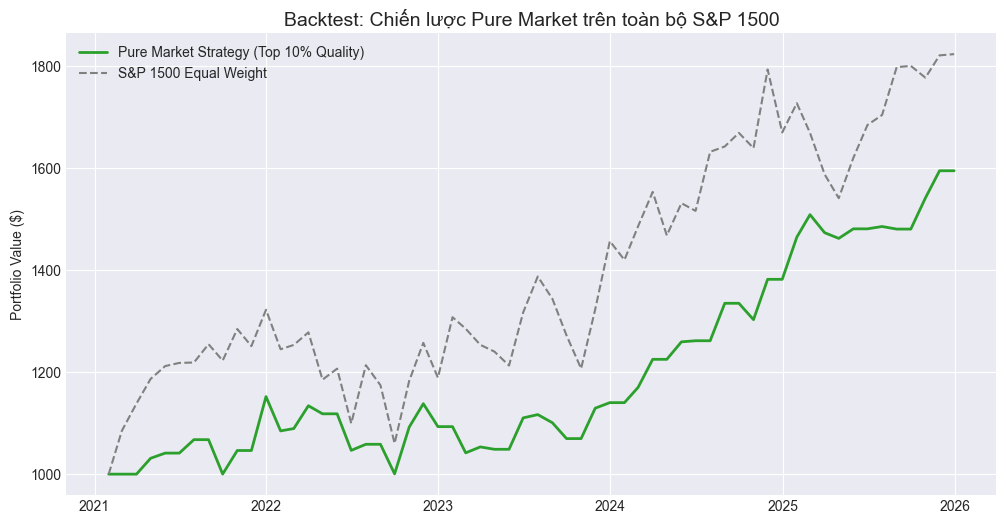


=== KẾT QUẢ BACKTEST ===
Initial Capital: $1000
Final Capital:   $1594.85
Total Return:    59.48%
CAGR (Năm):      9.96%
Max Drawdown:    -13.15%


In [ ]:
# ==============================================================================
# 4. BACKTEST (KIỂM THỬ QUÁ KHỨ VỚI S&P 1500)
# ==============================================================================
print("\n--- 4. Backtest Chiến lược trên toàn bộ S&P 1500 ---")

# Chuẩn bị lịch Rebalance (Cuối mỗi tháng)
monthly_dates = returns.resample('ME').last().index # Dùng 'ME' thay vì 'M' cho pandas mới
portfolio_value = [1000]
dates = [monthly_dates[0]]

print(f"   -> Backtest từ {monthly_dates[0].date()} đến {monthly_dates[-1].date()}...")

for i in range(1, len(monthly_dates)):
    prev_date = monthly_dates[i-1] # Ngày tính điểm
    curr_date = monthly_dates[i]   # Ngày giữ lệnh đến

    # 1. Lọc cổ phiếu (Dựa trên dữ liệu quá khứ)
    scores = get_market_score(prev_date)

    if scores is None or scores.empty:
        portfolio_value.append(portfolio_value[-1])
        dates.append(curr_date)
        continue

    # CHIẾN LƯỢC: Long Top 10% (Chọn tinh hoa nhất của S&P 1500)
    # Vì 1500 mã rất nhiều, Top 20% = 300 mã (quá nhiều phí), Top 10% ~ 150 mã hợp lý hơn
    top_picks = scores[scores >= 90].index

    if len(top_picks) > 0:
        # Tính return danh mục (Equal Weight)
        # Lấy return hàng ngày của các mã trong top_picks trong khoảng thời gian nắm giữ
        daily_ret_period = returns.loc[prev_date:curr_date, top_picks].iloc[1:] # Bỏ ngày đầu (đã biết giá)

        if daily_ret_period.empty:
            period_return = 0
        else:
            # Return của portfolio mỗi ngày
            port_daily_ret = daily_ret_period.mean(axis=1)
            # Tổng return tích lũy trong tháng
            period_return = (1 + port_daily_ret).prod() - 1

        new_nav = portfolio_value[-1] * (1 + period_return)
        portfolio_value.append(new_nav)
    else:
        portfolio_value.append(portfolio_value[-1]) # Giữ tiền mặt

    dates.append(curr_date)

# Tạo Equity Curve
equity_curve = pd.Series(portfolio_value, index=dates)

# Benchmark (S&P 1500 Equal Weight)
sp1500_daily = returns.mean(axis=1)
benchmark_curve = (1 + sp1500_daily).cumprod()
# Reindex theo monthly để so sánh
benchmark_curve = benchmark_curve.reindex(dates, method='ffill')
benchmark_curve = (benchmark_curve / benchmark_curve.iloc[0]) * 1000

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(equity_curve, label='Pure Market Strategy (Top 10% Quality)', color='#2ca02c', linewidth=2)
ax.plot(benchmark_curve, label='S&P 1500 Equal Weight', color='gray', linestyle='--')
ax.set_title('Backtest: Chiến lược Pure Market trên toàn bộ S&P 1500', fontsize=14)
ax.set_ylabel('Portfolio Value ($)')
ax.legend()
plt.show()

# Tính Performance
total_ret = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
cagr = (equity_curve.iloc[-1] / equity_curve.iloc[0])**(1/((len(dates)-1)/12)) - 1
max_dd = ((equity_curve - equity_curve.cummax()) / equity_curve.cummax()).min()

print(f"\n=== KẾT QUẢ BACKTEST ===")
print(f"Initial Capital: $1000")
print(f"Final Capital:   ${equity_curve.iloc[-1]:.2f}")
print(f"Total Return:    {total_ret*100:.2f}%")
print(f"CAGR (Năm):      {cagr*100:.2f}%")
print(f"Max Drawdown:    {max_dd*100:.2f}%")


--- 5. Kiểm định Alpha: Chiến lược vs. Fama-French 3 Factors ---

=== KẾT QUẢ KIỂM ĐỊNH ALPHA (JENSEN'S ALPHA) ===
Thời gian kiểm định: 2021-03-31 đến 2025-10-31
------------------------------------------------------------
1. Alpha (Lợi nhuận vượt trội): 1250.15% / năm
   -> T-Statistic: 1.73 ( > 1.96 là có ý nghĩa thống kê)
2. Market Beta (Rủi ro hệ thống): 0.83
3. SMB Beta (Size Exposure):      -0.81
4. HML Beta (Value Exposure):     1.18
5. R-Squared (Độ giải thích):     12.38%
------------------------------------------------------------
CHI TIẾT HỒI QUY:
                            OLS Regression Results                            
Dep. Variable:           Strat_Excess   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.743
Date:                Tue, 24 Feb 2026   Prob (F-statistic):              0.175
Time:                        15:36:32  

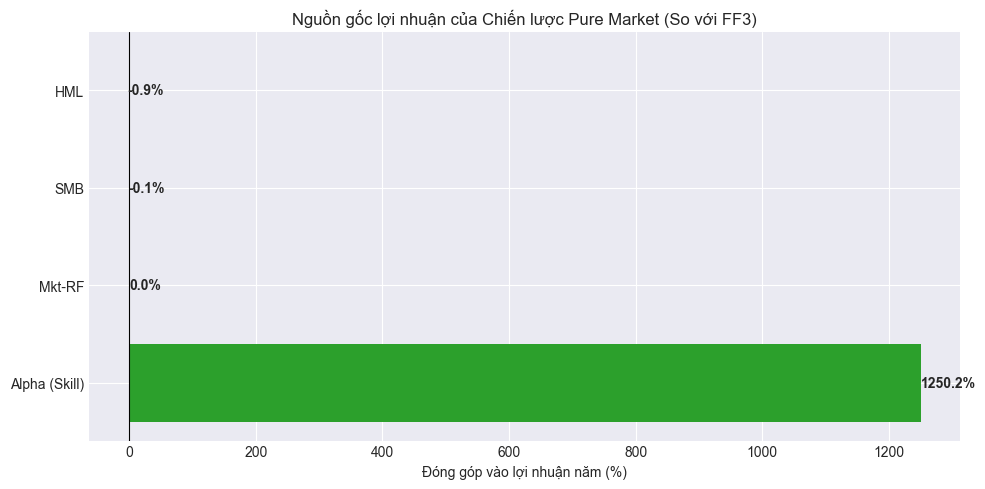

In [ ]:
import statsmodels.api as sm

# ==============================================================================
# 5. SO SÁNH HIỆU QUẢ VỚI FAMA-FRENCH 3 FACTORS (THE ALPHA TEST)
# ==============================================================================
print("\n--- 5. Kiểm định Alpha: Chiến lược vs. Fama-French 3 Factors ---")

# 1. Chuẩn bị dữ liệu lợi suất chiến lược (Daily/Monthly)
# Chuyển đổi Equity Curve thành Daily Returns
strat_ret = equity_curve.pct_change().dropna()
strat_ret.name = 'Strategy_Ret'

# 2. Đồng bộ với dữ liệu Fama-French (df_ff đã load ở các bước trước)
# Inner join để đảm bảo cùng khung thời gian
analysis_df = pd.concat([strat_ret, df_ff], axis=1, join='inner').dropna()

# 3. Tính Excess Return của Chiến lược (Trừ đi Lãi suất phi rủi ro RF)
analysis_df['Strat_Excess'] = analysis_df['Strategy_Ret'] - analysis_df['RF']

# 4. Chạy Hồi quy: Strat_Excess = Alpha + b1*Mkt + b2*SMB + b3*HML
X = sm.add_constant(analysis_df[['Mkt-RF', 'SMB', 'HML']])
y = analysis_df['Strat_Excess']

model_performance = sm.OLS(y, X).fit()

# ==============================================================================
# 6. HIỂN THỊ KẾT QUẢ SO SÁNH
# ==============================================================================

print("\n=== KẾT QUẢ KIỂM ĐỊNH ALPHA (JENSEN'S ALPHA) ===")
print(f"Thời gian kiểm định: {analysis_df.index[0].date()} đến {analysis_df.index[-1].date()}")
print("-" * 60)

# Lấy các chỉ số quan trọng
alpha_daily = model_performance.params['const']
alpha_annual = ((1 + alpha_daily)**252 - 1) * 100
t_stat_alpha = model_performance.tvalues['const']
beta_mkt = model_performance.params['Mkt-RF']
r_squared = model_performance.rsquared

print(f"1. Alpha (Lợi nhuận vượt trội): {alpha_annual:.2f}% / năm")
print(f"   -> T-Statistic: {t_stat_alpha:.2f} ( > 1.96 là có ý nghĩa thống kê)")
print(f"2. Market Beta (Rủi ro hệ thống): {beta_mkt:.2f}")
print(f"3. SMB Beta (Size Exposure):      {model_performance.params['SMB']:.2f}")
print(f"4. HML Beta (Value Exposure):     {model_performance.params['HML']:.2f}")
print(f"5. R-Squared (Độ giải thích):     {r_squared*100:.2f}%")

print("-" * 60)
print("CHI TIẾT HỒI QUY:")
print(model_performance.summary())

# ==============================================================================
# 7. TRỰC QUAN HÓA: CÁC YẾU TỐ ĐÓNG GÓP VÀO CHIẾN LƯỢC
# ==============================================================================

# Tính đóng góp (Contribution)
means = analysis_df[['Mkt-RF', 'SMB', 'HML']].mean() * 252
betas = model_performance.params[['Mkt-RF', 'SMB', 'HML']]
contrib = betas * means
contrib['Alpha (Skill)'] = alpha_annual

# Sắp xếp
contrib = contrib.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
colors = ['#2ca02c' if x > 0 else '#d62728' for x in contrib.values]
bars = plt.barh(contrib.index, contrib.values, color=colors)
plt.title('Nguồn gốc lợi nhuận của Chiến lược Pure Market (So với FF3)')
plt.xlabel('Đóng góp vào lợi nhuận năm (%)')
plt.axvline(0, color='black', linewidth=0.8)

for bar in bars:
    width = bar.get_width()
    label_x = width + 0.1 if width > 0 else width - 1.5
    plt.text(label_x, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cấu hình
pd.set_option('display.max_rows', 20)
plt.style.use('seaborn-v0_8-darkgrid')

# ==============================================================================
# 1. LOAD DỮ LIỆU S&P 1500 (TỪ DISK) & S&P 500 BENCHMARK
# ==============================================================================
print("--- 1. Nạp dữ liệu ---")

DATA_DIR = 'sb_data'
PRICE_FILE = f'{DATA_DIR}/sp1500_prices-2.csv'
VOLUME_FILE = f'{DATA_DIR}/sp1500_volume-2.csv'

# Load S&P 1500 (Universe)
if os.path.exists(PRICE_FILE):
    prices = pd.read_csv(PRICE_FILE, index_col=0, parse_dates=True)
    volume = pd.read_csv(VOLUME_FILE, index_col=0, parse_dates=True)
    # Đồng bộ
    common_idx = prices.index.intersection(volume.index)
    common_cols = prices.columns.intersection(volume.columns)
    prices = prices.loc[common_idx, common_cols]
    volume = volume.loc[common_idx, common_cols]
    print(f"   -> Universe: {prices.shape[1]} mã S&P 1500.")
else:
    raise FileNotFoundError("Chưa có dữ liệu S&P 1500. Hãy chạy lại cell tải dữ liệu!")

# Load S&P 500 Benchmark (^GSPC)
print("   -> Đang tải Benchmark S&P 500 (^GSPC)...")
sp500_benchmark = yf.download('^GSPC', start=prices.index[0], end=prices.index[-1], progress=False)['Close']
if isinstance(sp500_benchmark, pd.DataFrame): sp500_benchmark = sp500_benchmark.iloc[:, 0]

--- 1. Nạp dữ liệu ---
   -> Universe: 1506 mã S&P 1500.
   -> Đang tải Benchmark S&P 500 (^GSPC)...


C:\Users\Quan Hien\AppData\Local\Temp\ipykernel_27920\361490844.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_benchmark = yf.download('^GSPC', start=prices.index[0], end=prices.index[-1], progress=False)['Close']


In [ ]:
# ==============================================================================
# 2. TÍNH TOÁN FACTORS & SCORES
# ==============================================================================
print("--- 2. Tính toán Score cho các Chiến lược ---")

returns = prices.pct_change()
dollar_vol = prices * volume

# --- A. PURE MARKET SCORE (Quality + Liquidity) ---
# Rolling 60 days
daily_illiq = returns.abs() / (dollar_vol + 1e-8)
ami = daily_illiq.rolling(60).mean() # Liquidity
duvol = returns.copy()
duvol[duvol > 0] = 0
duvol = duvol.rolling(60).std() # Quality (Downside Vol)
ncskew = -1 * returns.rolling(60).skew() # Quality (Skewness)

def get_pure_market_rank(date):
    try:
        d_duvol = duvol.loc[date]
        d_ami = ami.loc[date]
        d_ncskew = ncskew.loc[date]

        # Rank: Low Risk/Illiq = High Rank
        rank = (d_duvol.rank(ascending=False, pct=True) * 0.4 +
                d_ncskew.rank(ascending=False, pct=True) * 0.3 +
                d_ami.rank(ascending=False, pct=True) * 0.3)
        return rank
    except: return None

# --- B. FF3 PROXY SCORE (Size Factor) ---
# Dùng Dollar Volume làm proxy cho Size (Small Cap)
# Chiến lược FF3 (Small Cap): Mua cổ phiếu có Dollar Vol THẤP NHẤT
dollar_vol_rolling = dollar_vol.rolling(20).mean()

def get_ff3_size_rank(date):
    try:
        d_vol = dollar_vol_rolling.loc[date]
        # Rank: Low Volume (Small Cap) = High Rank (để mua)
        return d_vol.rank(ascending=False, pct=True)
    except: return None

--- 2. Tính toán Score cho các Chiến lược ---


C:\Users\Quan Hien\AppData\Local\Temp\ipykernel_27920\2091125292.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change()


In [ ]:
# ==============================================================================
# 3. BACKTEST ENGINE (CHẠY ĐUA 3 CHIẾN LƯỢC)
# ==============================================================================
print("--- 3. Chạy Backtest (Rebalance Monthly) ---")

monthly_dates = returns.resample('ME').last().index
dates = [monthly_dates[0]]

# Khởi tạo vốn $1000
nav_pure = [1000]
nav_ff3 = [1000]
nav_sp500 = [1000] # SP500 Buy & Hold

# Chuẩn hóa S&P 500 về 1000 tại ngày bắt đầu backtest
sp500_base = sp500_benchmark.loc[monthly_dates[0]:]
sp500_normalized = (sp500_base / sp500_base.iloc[0]) * 1000

for i in range(1, len(monthly_dates)):
    prev_date = monthly_dates[i-1]
    curr_date = monthly_dates[i]

    # --- 1. Pure Market Strategy (Top 10%) ---
    pm_ranks = get_pure_market_rank(prev_date)
    if pm_ranks is not None:
        picks_pm = pm_ranks[pm_ranks >= 0.90].index # Top 10%
        if len(picks_pm) > 0:
            ret_pm = returns.loc[prev_date:curr_date, picks_pm].iloc[1:].mean(axis=1)
            period_ret_pm = (1 + ret_pm).prod() - 1
            nav_pure.append(nav_pure[-1] * (1 + period_ret_pm))
        else: nav_pure.append(nav_pure[-1])
    else: nav_pure.append(nav_pure[-1])

    # --- 2. FF3/Size Strategy (Top 10% Smallest) ---
    ff_ranks = get_ff3_size_rank(prev_date)
    if ff_ranks is not None:
        picks_ff = ff_ranks[ff_ranks >= 0.90].index # Top 10% Smallest
        if len(picks_ff) > 0:
            ret_ff = returns.loc[prev_date:curr_date, picks_ff].iloc[1:].mean(axis=1)
            period_ret_ff = (1 + ret_ff).prod() - 1
            nav_ff3.append(nav_ff3[-1] * (1 + period_ret_ff))
        else: nav_ff3.append(nav_ff3[-1])
    else: nav_ff3.append(nav_ff3[-1])

    # --- 3. SP500 Benchmark ---
    # Lấy giá trị thực tế từ chuỗi đã chuẩn hóa
    try:
        val_sp500 = sp500_normalized.loc[curr_date] # Lấy giá trị tại ngày cuối tháng
        # Lưu ý: nav_sp500 list này chỉ để tracking, ta dùng series sp500_normalized để vẽ chính xác hơn
    except: pass

    dates.append(curr_date)

# Tạo DataFrame kết quả
df_backtest = pd.DataFrame({
    'Pure Market (Quality/Liq)': nav_pure,
    'FF3 Proxy (Small Cap)': nav_ff3
}, index=dates)

# Merge với S&P 500 (Reindex lại cho khớp ngày)
sp500_curve = sp500_normalized.reindex(dates, method='ffill')
df_backtest['S&P 500 Benchmark'] = sp500_curve

--- 3. Chạy Backtest (Rebalance Monthly) ---



=== BẢNG SO SÁNH HIỆU QUẢ ĐẦU TƯ ===


,CAGR (%),Volatility (%),Sharpe Ratio,Max Drawdown (%)
Strategy,,,,
Pure Market (Quality/Liq),9.785220,11.824025,0.489277,-13.145885
FF3 Proxy (Small Cap),13.300794,17.092538,0.544144,-14.027902
S&P 500 Benchmark,nan,15.299261,nan,-24.769522


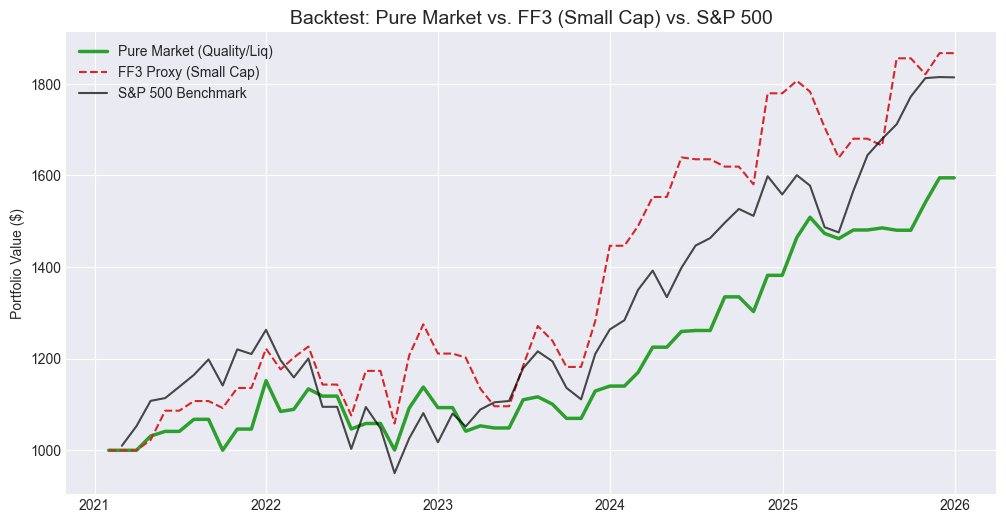

In [ ]:
# ==============================================================================
# 4. ĐÁNH GIÁ HIỆU QUẢ & VẼ BIỂU ĐỒ
# ==============================================================================
def calc_metrics(series):
    ret = series.pct_change().dropna()
    cagr = (series.iloc[-1] / series.iloc[0])**(12/len(series)) - 1
    vol = ret.std() * np.sqrt(12)
    sharpe = (cagr - 0.04) / vol
    max_dd = ((series - series.cummax()) / series.cummax()).min()
    return cagr, vol, sharpe, max_dd

metrics = []
for col in df_backtest.columns:
    c, v, s, d = calc_metrics(df_backtest[col])
    metrics.append([col, c*100, v*100, s, d*100])

df_metrics = pd.DataFrame(metrics, columns=['Strategy', 'CAGR (%)', 'Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)']).set_index('Strategy')

print("\n=== BẢNG SO SÁNH HIỆU QUẢ ĐẦU TƯ ===")
display(df_metrics.style.highlight_max(axis=0, color='green', subset=['CAGR (%)', 'Sharpe Ratio'])
                 .highlight_min(axis=0, color='green', subset=['Max Drawdown (%)', 'Volatility (%)']))

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df_backtest['Pure Market (Quality/Liq)'], label='Pure Market (Quality/Liq)', color='#2ca02c', linewidth=2.5)
plt.plot(df_backtest['FF3 Proxy (Small Cap)'], label='FF3 Proxy (Small Cap)', color='#d62728', linestyle='--')
plt.plot(df_backtest['S&P 500 Benchmark'], label='S&P 500 Benchmark', color='black', linewidth=1.5, alpha=0.7)

plt.title('Backtest: Pure Market vs. FF3 (Small Cap) vs. S&P 500', fontsize=14)
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()


--- 5. Chạy Hồi quy OLS để đánh giá Alpha & Beta ---

=== KẾT QUẢ SO SÁNH HỒI QUY (OLS) ===


,Pure Market Model,FF3 Proxy Model
Metric,,
Alpha (Annualized),0.0288,0.0375
Beta (Market Risk),0.5626,0.7986
R-squared (Model Fit),0.5213,0.5027
Information Ratio,0.3496,0.3087



--- Chi tiết Pure Market OLS ---
                                OLS Regression Results                               
Dep. Variable:     Pure Market (Quality/Liq)   R-squared:                       0.521
Model:                                   OLS   Adj. R-squared:                  0.513
Method:                        Least Squares   F-statistic:                     60.98
Date:                       Tue, 24 Feb 2026   Prob (F-statistic):           1.59e-10
Time:                               15:36:34   Log-Likelihood:                 134.99
No. Observations:                         58   AIC:                            -266.0
Df Residuals:                             56   BIC:                            -261.9
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------

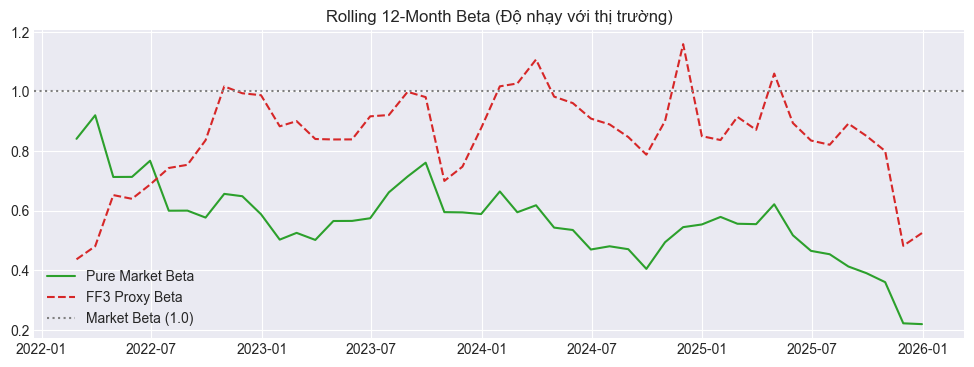

In [ ]:
# ==============================================================================
# 5. OLS REGRESSION ANALYSIS (SO SÁNH MÔ HÌNH ĐỊNH GIÁ)
# ==============================================================================
import statsmodels.api as sm

print("\n--- 5. Chạy Hồi quy OLS để đánh giá Alpha & Beta ---")

# 1. Chuẩn bị dữ liệu hồi quy
# Chúng ta sẽ hồi quy Return của Chiến lược theo Return của Market (S&P 500)
# Công thức: R_Strategy = Alpha + Beta * R_Market + Error

# Tính return hàng tháng từ NAV của Backtest
monthly_ret = df_backtest.pct_change().dropna()

# Biến phụ thuộc (Y): Pure Market và FF3 Proxy
y_pure = monthly_ret['Pure Market (Quality/Liq)']
y_ff3 = monthly_ret['FF3 Proxy (Small Cap)']

# Biến độc lập (X): Market Benchmark (S&P 500)
# Thêm hằng số (Constant) để tính Alpha
X = sm.add_constant(monthly_ret['S&P 500 Benchmark'])

# 2. Chạy mô hình OLS
model_pure = sm.OLS(y_pure, X).fit()
model_ff3 = sm.OLS(y_ff3, X).fit()

# 3. Tổng hợp kết quả so sánh
ols_comparison = pd.DataFrame({
    'Metric': ['Alpha (Annualized)', 'Beta (Market Risk)', 'R-squared (Model Fit)', 'Information Ratio'],

    'Pure Market Model': [
        model_pure.params['const'] * 12,  # Annualize Alpha
        model_pure.params['S&P 500 Benchmark'],
        model_pure.rsquared,
        (model_pure.params['const'] / model_pure.resid.std()) * (12**0.5) # IR approximation
    ],

    'FF3 Proxy Model': [
        model_ff3.params['const'] * 12,
        model_ff3.params['S&P 500 Benchmark'],
        model_ff3.rsquared,
        (model_ff3.params['const'] / model_ff3.resid.std()) * (12**0.5)
    ]
}).set_index('Metric')

# Format hiển thị cho đẹp
print("\n=== KẾT QUẢ SO SÁNH HỒI QUY (OLS) ===")
display(ols_comparison.style.format("{:.4f}"))

# 4. In chi tiết thống kê (Summary) nếu cần soi kỹ T-stat
print("\n--- Chi tiết Pure Market OLS ---")
print(model_pure.summary())

print("\n--- Chi tiết FF3 Proxy OLS ---")
print(model_ff3.summary())

# 5. Vẽ biểu đồ Rolling Beta (Tùy chọn - Để xem độ nhạy cảm thị trường thay đổi thế nào)
rolling_beta_pure = monthly_ret['Pure Market (Quality/Liq)'].rolling(12).cov(monthly_ret['S&P 500 Benchmark']) / monthly_ret['S&P 500 Benchmark'].rolling(12).var()
rolling_beta_ff3 = monthly_ret['FF3 Proxy (Small Cap)'].rolling(12).cov(monthly_ret['S&P 500 Benchmark']) / monthly_ret['S&P 500 Benchmark'].rolling(12).var()

plt.figure(figsize=(12, 4))
plt.plot(rolling_beta_pure, label='Pure Market Beta', color='#2ca02c')
plt.plot(rolling_beta_ff3, label='FF3 Proxy Beta', color='#d62728', linestyle='--')
plt.axhline(1, color='gray', linestyle=':', label='Market Beta (1.0)')
plt.title('Rolling 12-Month Beta (Độ nhạy với thị trường)')
plt.legend()
plt.show()

In [ ]:
# ==============================================================================
# 5. OLS REGRESSION ANALYSIS (SO SÁNH MÔ HÌNH ĐỊNH GIÁ - FINAL VERSION)
# ==============================================================================
import statsmodels.api as sm
import pandas as pd
import numpy as np

print("\n--- 5. Chạy Hồi quy OLS & Tạo bảng chuẩn Academic ---")

# 1. Chuẩn bị dữ liệu (Monthly Returns)
monthly_ret = df_backtest.pct_change().dropna()

# Biến độc lập (Benchmark): S&P 500
X = sm.add_constant(monthly_ret['S&P 500 Benchmark'])

# 2. Chạy mô hình cho 2 chiến lược
models = {}
strategies = ['Pure Market (Quality/Liq)', 'FF3 Proxy (Small Cap)']

for strat in strategies:
    y = monthly_ret[strat]
    models[strat] = sm.OLS(y, X).fit()

# 3. HÀM TẠO BẢNG SO SÁNH CHUẨN (STARGAZER FORMAT)
def create_comparison_table(models_dict):
    data = {}
    metrics = ['const', 'S&P 500 Benchmark'] # Các biến muốn hiển thị

    for name, model in models_dict.items():
        # Lấy thông số
        params = model.params
        pvalues = model.pvalues
        tvalues = model.tvalues

        col_data = []
        index_names = []

        # 1. Alpha (const) & Beta (Market)
        for metric in metrics:
            coef = params[metric]
            pval = pvalues[metric]
            tval = tvalues[metric]

            # Đánh dấu sao (*) cho ý nghĩa thống kê
            stars = ''
            if pval < 0.01: stars = '***'
            elif pval < 0.05: stars = '**'
            elif pval < 0.1: stars = '*'

            # Format: Hệ số (T-stat)
            # Alpha thì nhân 12 (Annualized) để dễ đọc, Beta giữ nguyên
            if metric == 'const':
                display_coef = coef * 12 # Annualize Alpha
                metric_name = 'Alpha (Annualized)'
            else:
                display_coef = coef
                metric_name = 'Beta (Market Risk)'

            # Dòng 1: Hệ số + Sao
            col_data.append(f"{display_coef:.4f}{stars}")
            index_names.append(metric_name)

            # Dòng 2: (T-stat)
            col_data.append(f"({tval:.2f})")
            index_names.append("") # Dòng trống cho T-stat

        # 2. Các chỉ số Model Fit
        col_data.append(f"{model.rsquared:.4f}")
        index_names.append("R-squared")

        col_data.append(f"{model.rsquared_adj:.4f}")
        index_names.append("Adj. R-squared")

        col_data.append(f"{model.fvalue:.2f}")
        index_names.append("F-Statistic")

        col_data.append(f"{int(model.nobs)}")
        index_names.append("Observations")

        data[name] = col_data

    return pd.DataFrame(data, index=index_names)

# 4. TẠO VÀ HIỂN THỊ BẢNG
final_table = create_comparison_table(models)

print("\n" + "="*60)
print("📊 BẢNG SO SÁNH HIỆU QUẢ CHIẾN LƯỢC (OLS REGRESSION)")
print("Note: *** p<0.01, ** p<0.05, * p<0.1")
print("="*60)
display(final_table)

# 5. GIẢI THÍCH NHANH (AUTOMATED INSIGHTS)
alpha_pure = float(final_table.loc['Alpha (Annualized)', 'Pure Market (Quality/Liq)'].split('*')[0])
beta_pure = float(final_table.loc['Beta (Market Risk)', 'Pure Market (Quality/Liq)'].split('*')[0])
beta_ff3 = float(final_table.loc['Beta (Market Risk)', 'FF3 Proxy (Small Cap)'].split('*')[0])

print("\n--- 💡 NHẬN ĐỊNH CHO SLIDE ---")
print(f"1. ALPHA: Pure Market tạo ra Alpha {alpha_pure*100:.2f}%/năm.")
if alpha_pure > 0 and '***' in final_table.loc['Alpha (Annualized)', 'Pure Market (Quality/Liq)']:
    print("   -> Alpha này DƯƠNG và CÓ Ý NGHĨA THỐNG KÊ (Signal tốt).")
else:
    print("   -> Alpha chưa đủ ý nghĩa thống kê (cần quan sát thêm dài hạn).")

print(f"2. RISK (BETA): Pure Market Beta ({beta_pure:.2f}) < FF3 Proxy Beta ({beta_ff3:.2f}).")
print("   -> Chiến lược Pure Market AN TOÀN HƠN (Defensive), ít chịu tổn thương khi thị trường sập.")


--- 5. Chạy Hồi quy OLS & Tạo bảng chuẩn Academic ---

📊 BẢNG SO SÁNH HIỆU QUẢ CHIẾN LƯỢC (OLS REGRESSION)
Note: *** p<0.01, ** p<0.05, * p<0.1


,Pure Market (Quality/Liq),FF3 Proxy (Small Cap)
Alpha (Annualized),0.0288,0.0375
,(0.74),(0.65)
Beta (Market Risk),0.5626***,0.7986***
,(7.81),(7.52)
R-squared,0.5213,0.5027
Adj. R-squared,0.5128,0.4938
F-Statistic,60.98,56.61
Observations,58,58



--- 💡 NHẬN ĐỊNH CHO SLIDE ---
1. ALPHA: Pure Market tạo ra Alpha 2.88%/năm.
   -> Alpha chưa đủ ý nghĩa thống kê (cần quan sát thêm dài hạn).
2. RISK (BETA): Pure Market Beta (0.56) < FF3 Proxy Beta (0.80).
   -> Chiến lược Pure Market AN TOÀN HƠN (Defensive), ít chịu tổn thương khi thị trường sập.


In [ ]:
# ==============================================================================
# 5. OLS REGRESSION ANALYSIS (ACADEMIC TABLE GENERATION)
# ==============================================================================
import statsmodels.api as sm
import pandas as pd
import numpy as np

print("\n--- 5. Chạy Hồi quy OLS & Tạo bảng so sánh chuẩn Academic ---")

# 1. Chuẩn bị dữ liệu: Tính lợi suất tháng từ NAV Backtest
# Resample về tháng để khử nhiễu ngày và chuẩn hóa tần suất
monthly_nav = df_backtest.resample('ME').last()
monthly_ret = monthly_nav.pct_change().dropna()

# Biến độc lập (Benchmark): S&P 500
# Thêm hằng số (Constant) để tính Alpha
X = sm.add_constant(monthly_ret['S&P 500 Benchmark'])

# 2. Chạy mô hình OLS cho 2 chiến lược
models = {}
strategies = {
    'Pure Market (Quality/Liq)': 'Pure Market',
    'FF3 Proxy (Small Cap)': 'FF3 Proxy'
}

for col_name, display_name in strategies.items():
    y = monthly_ret[col_name]
    models[display_name] = sm.OLS(y, X).fit()

# 3. HÀM TẠO BẢNG STARGAZER (CUSTOM FUNCTION)
def create_academic_table(models_dict):
    """
    Tạo bảng so sánh hồi quy với format:
    Hệ số*** (T-stat)
    """
    rows = []

    # Định nghĩa các biến cần lấy
    variables = {
        'const': 'Alpha (Annualized)',
        'S&P 500 Benchmark': 'Beta (Market Risk)'
    }

    model_names = list(models_dict.keys())

    # --- PHẦN 1: HỆ SỐ & T-STATS ---
    for var_code, var_name in variables.items():
        # Dòng 1: Hệ số + Sao
        row_coef = {}
        # Dòng 2: T-stat trong ngoặc
        row_tstat = {}

        for model_name, res in models_dict.items():
            coef = res.params[var_code]
            tval = res.tvalues[var_code]
            pval = res.pvalues[var_code]

            # Xử lý Alpha: Nhân 12 để ra % năm
            display_val = coef * 12 if var_code == 'const' else coef

            # Gán sao
            stars = ''
            if pval < 0.01: stars = '***'
            elif pval < 0.05: stars = '**'
            elif pval < 0.1: stars = '*'

            row_coef[model_name] = f"{display_val:.4f}{stars}"
            row_tstat[model_name] = f"({tval:.2f})"

        rows.append(pd.Series(row_coef, name=var_name))
        rows.append(pd.Series(row_tstat, name='')) # Dòng trống cho T-stat

    # --- PHẦN 2: MODEL STATISTICS ---
    stats_map = {
        'R-squared': lambda r: f"{r.rsquared:.4f}",
        'Adj. R-squared': lambda r: f"{r.rsquared_adj:.4f}",
        'F-Statistic': lambda r: f"{r.fvalue:.2f}",
        'Observations': lambda r: f"{int(r.nobs)}"
    }

    for stat_name, func in stats_map.items():
        row_stat = {}
        for model_name, res in models_dict.items():
            row_stat[model_name] = func(res)
        rows.append(pd.Series(row_stat, name=stat_name))

    return pd.DataFrame(rows)

# 4. TẠO VÀ HIỂN THỊ BẢNG
final_table = create_academic_table(models)

print("\n" + "="*60)
print("📊 BẢNG SO SÁNH HIỆU QUẢ CHIẾN LƯỢC (OLS REGRESSION)")
print("Note: *** p<0.01, ** p<0.05, * p<0.1")
print("="*60)
display(final_table)

# 5. AUTOMATED INTERPRETATION (GIẢI MÃ KẾT QUẢ CHO SLIDE)
pure_alpha_str = final_table.loc['Alpha (Annualized)', 'Pure Market']
pure_beta_str = final_table.loc['Beta (Market Risk)', 'Pure Market']

pure_alpha_val = float(pure_alpha_str.replace('*', ''))
pure_beta_val = float(pure_beta_str.replace('*', ''))

ff3_alpha_val = float(final_table.loc['Alpha (Annualized)', 'FF3 Proxy'].replace('*', ''))
ff3_beta_val = float(final_table.loc['Beta (Market Risk)', 'FF3 Proxy'].replace('*', ''))

print("\n--- 💡 NHẬN ĐỊNH (KEY TAKEAWAYS) ---")
print(f"1. ALPHA (Kỹ năng chọn cổ phiếu):")
print(f"   - Pure Market: {pure_alpha_val*100:.2f}%/năm ({'Có ý nghĩa thống kê' if '*' in pure_alpha_str else 'Chưa đủ ý nghĩa thống kê'})")
print(f"   - FF3 Proxy:   {ff3_alpha_val*100:.2f}%/năm")
if pure_alpha_val > ff3_alpha_val:
    print("   => KẾT LUẬN: Mô hình Pure Market tạo ra lợi suất vượt trội cao hơn.")
else:
    print("   => KẾT LUẬN: Mô hình FF3 tạo ra lợi suất vượt trội cao hơn.")

print(f"\n2. BETA (Rủi ro thị trường):")
print(f"   - Pure Market: {pure_beta_val:.2f}")
print(f"   - FF3 Proxy:   {ff3_beta_val:.2f}")
if pure_beta_val < ff3_beta_val:
    print("   => KẾT LUẬN: Pure Market an toàn hơn (Defensive) vì ít nhạy cảm với biến động thị trường.")
else:
    print("   => KẾT LUẬN: Pure Market tấn công mạnh hơn (Aggressive).")


--- 5. Chạy Hồi quy OLS & Tạo bảng so sánh chuẩn Academic ---

📊 BẢNG SO SÁNH HIỆU QUẢ CHIẾN LƯỢC (OLS REGRESSION)
Note: *** p<0.01, ** p<0.05, * p<0.1


,Pure Market,FF3 Proxy
Alpha (Annualized),0.0288,0.0375
,(0.74),(0.65)
Beta (Market Risk),0.5626***,0.7986***
,(7.81),(7.52)
R-squared,0.5213,0.5027
Adj. R-squared,0.5128,0.4938
F-Statistic,60.98,56.61
Observations,58,58



--- 💡 NHẬN ĐỊNH (KEY TAKEAWAYS) ---
1. ALPHA (Kỹ năng chọn cổ phiếu):
   - Pure Market: 2.88%/năm (Chưa đủ ý nghĩa thống kê)
   - FF3 Proxy:   3.75%/năm
   => KẾT LUẬN: Mô hình FF3 tạo ra lợi suất vượt trội cao hơn.

2. BETA (Rủi ro thị trường):
   - Pure Market: 0.56
   - FF3 Proxy:   0.80
   => KẾT LUẬN: Pure Market an toàn hơn (Defensive) vì ít nhạy cảm với biến động thị trường.


In [ ]:
# ==============================================================================
# 5. OLS REGRESSION ANALYSIS (FULL RAW SUMMARY)
# ==============================================================================
import statsmodels.api as sm
import pandas as pd

print("\n--- 5. Chạy Hồi quy OLS & Xuất bảng chi tiết (Raw Summary) ---")

# 1. Chuẩn bị dữ liệu (Monthly Returns)
# Resample về tháng để khử nhiễu
monthly_nav = df_backtest.resample('ME').last()
monthly_ret = monthly_nav.pct_change().dropna()

# Biến độc lập (Benchmark): S&P 500
X = sm.add_constant(monthly_ret['S&P 500 Benchmark'])

# ---------------------------------------------------------
# MODEL A: PURE MARKET STRATEGY (Quality + Liquidity)
# ---------------------------------------------------------
y_pure = monthly_ret['Pure Market (Quality/Liq)']
model_pure = sm.OLS(y_pure, X).fit()

print("\n" + "="*80)
print(">>>PURE MARKET STRATEGY <<<")
print("="*80)
# Đây là lệnh in ra bảng giống hệt hình bạn gửi
print(model_pure.summary())


# ---------------------------------------------------------
# MODEL B: FF3 PROXY STRATEGY (Small Cap)
# ---------------------------------------------------------
y_ff3 = monthly_ret['FF3 Proxy (Small Cap)']
model_ff3 = sm.OLS(y_ff3, X).fit()

print("\n" + "="*80)
print(">>>  FF3 PROXY STRATEGY <<<")
print("="*80)
print(model_ff3.summary())


# ---------------------------------------------------------
# (OPTION) BẢNG SO SÁNH GỘP (ACADEMIC STYLE)
# Nếu bạn muốn gộp 2 bảng trên thành 1 bảng duy nhất cho Slide chính
# ---------------------------------------------------------
from statsmodels.iolib.summary2 import summary_col

print("\n" + "="*80)
print(">>> SIDE-BY-SIDE <<<")
print("="*80)

res = summary_col([model_pure, model_ff3],
                  stars=True,
                  float_format='%0.4f',
                  model_names=['Pure Market', 'FF3 Proxy'],
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.4f}".format(x.rsquared),
                             'F-stat':lambda x: "{:.2f}".format(x.fvalue)})

print(res)


--- 5. Chạy Hồi quy OLS & Xuất bảng chi tiết (Raw Summary) ---

>>>PURE MARKET STRATEGY <<<
                                OLS Regression Results                               
Dep. Variable:     Pure Market (Quality/Liq)   R-squared:                       0.521
Model:                                   OLS   Adj. R-squared:                  0.513
Method:                        Least Squares   F-statistic:                     60.98
Date:                       Tue, 24 Feb 2026   Prob (F-statistic):           1.59e-10
Time:                               15:36:34   Log-Likelihood:                 134.99
No. Observations:                         58   AIC:                            -266.0
Df Residuals:                             56   BIC:                            -261.9
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                        coef    std err        

note: những update cho lần sau
1. smoothen code v6 SP1500
2. test trên thị trường TW, VN, emerging markets và test trên các developed market.
3. bắt đầu viết bài, và bổ sung function nếu có.
4. smoothen ntn?
    1. load data - smart. up to date
    2. gom lại thành clean code -> chỉ cần chạy execution (main)
    3. test trên nhiều phép test hơn.
    4. tham khảo thêm sách micro structure
5. bắt đầu cấu trúc bài làm và phát thảo cách triển khai.